# Hotel Deals & Value Analysis - FILTERED COMPLETE DATASET

## 📅 DATE RANGE: November 14, 2025 - February 23, 2026
**This analysis focuses on our most complete dataset with near-full coverage.**

---

## 📋 IMPORTANT RULES & CONTEXT

### FHR (Fine Hotels & Resorts) Properties
**ALWAYS include by default:**
- ✓ Free Breakfast
- ✓ Late Check-out (4pm)
- ✓ Early Check-in (12pm)
- ✓ Room Upgrade (if available)

**Therefore:** Free breakfast is NOT a value differentiator for FHR properties.

### THC (The Hotel Collection) Properties
- Do NOT include free breakfast by default
- Free breakfast IS a significant value-add for THC

### Promotion Pricing Rules
1. **"Third Night Free" promos**: Already baked into pricing (we did 3-night searches)
2. **"Fourth/Fifth Night Free"**: NOT reflected in our rates (would need 4-5 night searches)
3. **Percent-off promos**: Already show the true discounted rate

### Pricing Considerations
- **Use `pricing_total_inclusive`** (includes taxes + fees)
- Taxes and fees vary SIGNIFICANTLY by country/city
- Can dramatically change the true cost and value proposition

### Rating Limitations
- **Star Rating**: Limited usefulness - almost all properties are 4-5 star
- **User Rating**: Need to validate if it correlates with value
- **Amenities**: Need to validate if they're meaningful differentiators

---

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime, timedelta
from pathlib import Path

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 8)

# Database path
DB_PATH = Path('../data/storage/hotels.sqlite3')

# DATE FILTER - Our most complete dataset
START_DATE = '2025-11-14'
END_DATE = '2026-02-23'

# Connect to database
conn = sqlite3.connect(DB_PATH)
print(f"✓ Connected to database: {DB_PATH}")
print(f"Database size: {DB_PATH.stat().st_size / (1024**3):.2f} GB")
print(f"\n📅 FILTERING FOR COMPLETE DATASET:")
print(f"   Check-in dates: {START_DATE} to {END_DATE}")
print(f"   Total days: {(pd.to_datetime(END_DATE) - pd.to_datetime(START_DATE)).days + 1}")

✓ Connected to database: ../data/storage/hotels.sqlite3
Database size: 20.45 GB

📅 FILTERING FOR COMPLETE DATASET:
   Check-in dates: 2025-11-14 to 2026-02-23
   Total days: 102


## 1. Database Overview & Data Volume

In [2]:
# Get table information
query = """
SELECT 
    name as table_name,
    type
FROM sqlite_master
WHERE type='table' AND name NOT LIKE 'sqlite_%'
ORDER BY name;
"""

tables_info = pd.read_sql_query(query, conn)
print("\nDatabase Tables:")
print("="*80)

# Get row counts for each table
table_stats = []
for table in tables_info['table_name']:
    count_query = f"SELECT COUNT(*) as count FROM {table}"
    count = pd.read_sql_query(count_query, conn)['count'][0]
    table_stats.append({'Table': table, 'Row Count': f"{count:,}"})

stats_df = pd.DataFrame(table_stats)
print(stats_df.to_string(index=False))


Database Tables:
                 Table Row Count
          destinations       173
        hotel_features   313,480
hotel_program_benefits    15,236
      hotel_promotions     1,124
                hotels     2,820
                  meta         1
       rate_components 3,872,860
   rate_nightly_prices 2,193,390
        rate_snapshots   737,956
            room_types    18,229
       search_payloads    22,175
           search_runs    22,253


## 2. Search Runs Overview (Filtered Dataset)

In [3]:
# Analyze search runs for our date range
date_query = f"""
SELECT 
    MIN(check_in) as earliest_check_in,
    MAX(check_in) as latest_check_in,
    COUNT(DISTINCT check_in) as unique_check_in_dates,
    COUNT(DISTINCT destination_key) as unique_destinations,
    COUNT(*) as total_search_runs,
    SUM(CASE WHEN status='complete' THEN 1 ELSE 0 END) as completed_runs,
    AVG(nights) as avg_nights,
    AVG(adults) as avg_adults,
    AVG(total_hotels) as avg_hotels_per_run,
    AVG(total_rates) as avg_rates_per_run
FROM search_runs
WHERE check_in >= '{START_DATE}' AND check_in <= '{END_DATE}';
"""

date_summary = pd.read_sql_query(date_query, conn)
print("\nSearch Runs Summary (Filtered):")
print("="*80)
for col in date_summary.columns:
    print(f"{col:30s}: {date_summary[col].iloc[0]}")


Search Runs Summary (Filtered):
earliest_check_in             : 2025-11-14
latest_check_in               : 2026-02-23
unique_check_in_dates         : 102
unique_destinations           : 173
total_search_runs             : 18681
completed_runs                : 18618
avg_nights                    : 2.994111664257802
avg_adults                    : 2.0
avg_hotels_per_run            : 17.829345324126116
avg_rates_per_run             : 55.431240297628605


## 3. Load Rate Data (Using Inclusive Pricing, Filtered)

In [22]:
# Load rate data - FILTERED to our complete dataset date range
rates_query = f"""
SELECT 
    rs.id as snapshot_id,
    rs.run_id,
    sr.check_in,
    sr.check_out,
    sr.nights,
    sr.adults,
    sr.destination_name,
    sr.destination_group,
    sr.program_filter,
    h.property_id,
    h.name as hotel_name,
    h.star_rating,
    h.user_rating,
    h.user_rating_count,
    h.brand_name,
    h.chain_name,
    h.address_city,
    h.address_country_name,
    rt.name as room_type_name,
    rs.pricing_currency,
    rs.pricing_total,
    rs.pricing_total_inclusive,
    rs.pricing_base,
    rs.pricing_total_fees,
    rs.pricing_total_taxes,
    rs.average_nightly_rate,
    rs.is_breakfast_included,
    rs.is_food_beverage_credit,
    rs.is_free_cancellation,
    rs.is_parking_included,
    rs.is_shuttle_included,
    rs.payment_model,
    rs.points_burn,
    rs.hotel_collection,
    rs.special_offer_json,
    rs.available
FROM rate_snapshots rs
JOIN search_runs sr ON rs.run_id = sr.id
JOIN hotels h ON rs.property_id = h.property_id
LEFT JOIN room_types rt ON rs.property_id = rt.property_id AND rs.room_type_id = rt.room_type_id
WHERE sr.status = 'complete'
    AND sr.check_in >= '{START_DATE}' AND sr.check_in <= '{END_DATE}'
    AND rs.pricing_total_inclusive IS NOT NULL
    AND rs.pricing_total_inclusive > 0;
"""

print(f"Loading rate data for {START_DATE} to {END_DATE}...")
rates_df = pd.read_sql_query(rates_query, conn)
print(f"✓ Loaded {len(rates_df):,} rate snapshots")

# Convert dates
rates_df['check_in'] = pd.to_datetime(rates_df['check_in'])
rates_df['check_out'] = pd.to_datetime(rates_df['check_out'])

# Calculate inclusive price per night
rates_df['price_per_night_inclusive'] = rates_df['pricing_total_inclusive'] / rates_df['nights']

# Identify collection type
rates_df['is_fhr'] = rates_df['hotel_collection'].fillna('').str.contains('FHR', case=False, na=False).astype(int)
rates_df['is_thc'] = rates_df['hotel_collection'].fillna('').str.contains('THC', case=False, na=False).astype(int)
rates_df['collection_type'] = 'Standard'
rates_df.loc[rates_df['is_fhr'] == 1, 'collection_type'] = 'FHR'
rates_df.loc[rates_df['is_thc'] == 1, 'collection_type'] = 'THC'

print(f"\nCollection Distribution:")
print(rates_df['collection_type'].value_counts())

print(f"\nDate Range Verification:")
print(f"  Earliest check-in: {rates_df['check_in'].min()}")
print(f"  Latest check-in: {rates_df['check_in'].max()}")
print(f"  Unique check-in dates: {rates_df['check_in'].nunique()}")
print(f"  Unique hotels: {rates_df['property_id'].nunique()}")
print(f"  Unique destinations: {rates_df['destination_name'].nunique()}")

# Display sample
print("\nSample of rate data:")
display(rates_df[['hotel_name', 'check_in', 'destination_name', 'collection_type', 
                   'price_per_night_inclusive', 'is_breakfast_included', 'user_rating']].head(10))

Loading rate data for 2025-11-14 to 2026-02-23...
✓ Loaded 565,593 rate snapshots

Collection Distribution:
collection_type
FHR    329216
THC    236377
Name: count, dtype: int64

Date Range Verification:
  Earliest check-in: 2025-11-14 00:00:00
  Latest check-in: 2026-02-23 00:00:00
  Unique check-in dates: 102
  Unique hotels: 2659
  Unique destinations: 166

Sample of rate data:


,hotel_name,check_in,destination_name,collection_type,price_per_night_inclusive,is_breakfast_included,user_rating
0,The Peninsula Tokyo,2026-01-01,Japan,FHR,2241.87,0,4.6
1,The Peninsula Tokyo,2026-01-01,Japan,FHR,2320.44,0,4.6
2,Andaz Tokyo Toranomon Hills - a concept by Hyatt,2026-01-01,Japan,FHR,1375.40,0,4.6
3,Andaz Tokyo Toranomon Hills - a concept by Hyatt,2026-01-01,Japan,FHR,1402.68,0,4.6
4,Grand Hyatt Tokyo,2026-01-01,Japan,FHR,1301.79,0,4.6
5,Grand Hyatt Tokyo,2026-01-01,Japan,FHR,1343.15,0,4.6
6,Fuji Speedway Hotel - The Unbound Collection b...,2026-01-01,Japan,FHR,663.61,0,NaN
7,Fuji Speedway Hotel - The Unbound Collection b...,2026-01-01,Japan,FHR,663.61,0,NaN
8,Conrad Osaka,2026-01-01,Japan,FHR,1030.03,0,4.7
9,Conrad Osaka,2026-01-01,Japan,FHR,1030.03,0,4.7


✓ Loaded 565,593 rate snapshots

Collection Distribution:
collection_type
FHR    329216
THC    236377
Name: count, dtype: int64

Date Range Verification:
  Earliest check-in: 2025-11-14 00:00:00
  Latest check-in: 2026-02-23 00:00:00
  Unique check-in dates: 102
  Unique hotels: 2659
  Unique destinations: 166

Sample of rate data:


,hotel_name,check_in,destination_name,collection_type,price_per_night_inclusive,is_breakfast_included,user_rating
0,The Peninsula Tokyo,2026-01-01,Japan,FHR,2241.87,0,4.6
1,The Peninsula Tokyo,2026-01-01,Japan,FHR,2320.44,0,4.6
2,Andaz Tokyo Toranomon Hills - a concept by Hyatt,2026-01-01,Japan,FHR,1375.40,0,4.6
3,Andaz Tokyo Toranomon Hills - a concept by Hyatt,2026-01-01,Japan,FHR,1402.68,0,4.6
4,Grand Hyatt Tokyo,2026-01-01,Japan,FHR,1301.79,0,4.6
5,Grand Hyatt Tokyo,2026-01-01,Japan,FHR,1343.15,0,4.6
6,Fuji Speedway Hotel - The Unbound Collection b...,2026-01-01,Japan,FHR,663.61,0,NaN
7,Fuji Speedway Hotel - The Unbound Collection b...,2026-01-01,Japan,FHR,663.61,0,NaN
8,Conrad Osaka,2026-01-01,Japan,FHR,1030.03,0,4.7
9,Conrad Osaka,2026-01-01,Japan,FHR,1030.03,0,4.7


## 4. Pricing Analysis - Understanding True Costs

In [ ]:
# Analyze the impact of taxes and fees
rates_df['tax_fee_amount'] = rates_df['pricing_total_inclusive'] - rates_df['pricing_total']
rates_df['tax_fee_percentage'] = (rates_df['tax_fee_amount'] / rates_df['pricing_total']) * 100

print("\n💰 PRICING ANALYSIS (Taxes & Fees Impact):")
print("="*80)
print(f"Average base price (3 nights): ${rates_df['pricing_total'].mean():.2f}")
print(f"Average inclusive price (3 nights): ${rates_df['pricing_total_inclusive'].mean():.2f}")
print(f"Average tax/fee amount: ${rates_df['tax_fee_amount'].mean():.2f}")
print(f"Average tax/fee percentage: {rates_df['tax_fee_percentage'].mean():.1f}%")
print(f"\nMax tax/fee percentage: {rates_df['tax_fee_percentage'].max():.1f}%")
print(f"Min tax/fee percentage: {rates_df['tax_fee_percentage'].min():.1f}%")

# Tax/fee distribution by country
tax_by_country = rates_df.groupby('address_country_name').agg({
    'tax_fee_percentage': 'mean',
    'snapshot_id': 'count'
}).rename(columns={'snapshot_id': 'count'}).sort_values('tax_fee_percentage', ascending=False).head(15)

print("\nTop 15 Countries by Tax/Fee Percentage:")
print(tax_by_country)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Tax/fee percentage distribution
axes[0].hist(rates_df['tax_fee_percentage'].clip(0, 50), bins=50, color='coral', alpha=0.7, edgecolor='black')
axes[0].axvline(rates_df['tax_fee_percentage'].mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {rates_df["tax_fee_percentage"].mean():.1f}%')
axes[0].set_title('Distribution of Tax & Fee Percentage', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Tax & Fee Percentage (%)')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Top countries
tax_by_country['tax_fee_percentage'].plot(kind='barh', ax=axes[1], color='steelblue', edgecolor='black')
axes[1].set_title('Average Tax/Fee % by Country (Top 15)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Tax & Fee Percentage (%)')
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


💰 PRICING ANALYSIS (Taxes & Fees Impact):
Average base price (3 nights): $2455.74
Average inclusive price (3 nights): $2523.19
Average tax/fee amount: $67.45
Average tax/fee percentage: 3.5%

Max tax/fee percentage: 155.0%
Min tax/fee percentage: 0.0%

Top 15 Countries by Tax/Fee Percentage:
                          tax_fee_percentage   count
address_country_name                                
Honduras                           15.663798     210
Maldives                           15.118406    4442
Puerto Rico                        14.376729    1929
Tanzania                           12.721181     864
Netherlands                        10.194272    4279
United States of America            7.407000  198034
Iceland                             7.389589     400
Cayman Islands                      6.924650    1377
US Virgin Islands                   6.921361     536
Aruba                               5.455300     873
Seychelles                          5.269573    1388
Montenegro       

## 5. Validate: Do User Ratings Correlate with Value?

/tmp/ipykernel_14416/2550059928.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rating_price_stats = user_rating_analysis.groupby('rating_bin').agg({



⭐ USER RATING vs PRICE ANALYSIS:
           price_per_night_inclusive                 user_rating
                                mean  median   count        mean
rating_bin                                                      
<3.5                          786.93  409.57    2442        3.19
3.5-4.0                       556.37  450.50   16864        3.88
4.0-4.3                       589.67  452.38   79250        4.23
4.3-4.5                       663.64  497.71  130753        4.46
4.5-4.7                       776.97  551.90  173667        4.65
4.7+                         1030.36  651.25  116470        4.85

Correlation between user rating and price: 0.148
⚠️  WEAK correlation - user rating may not be a strong value indicator


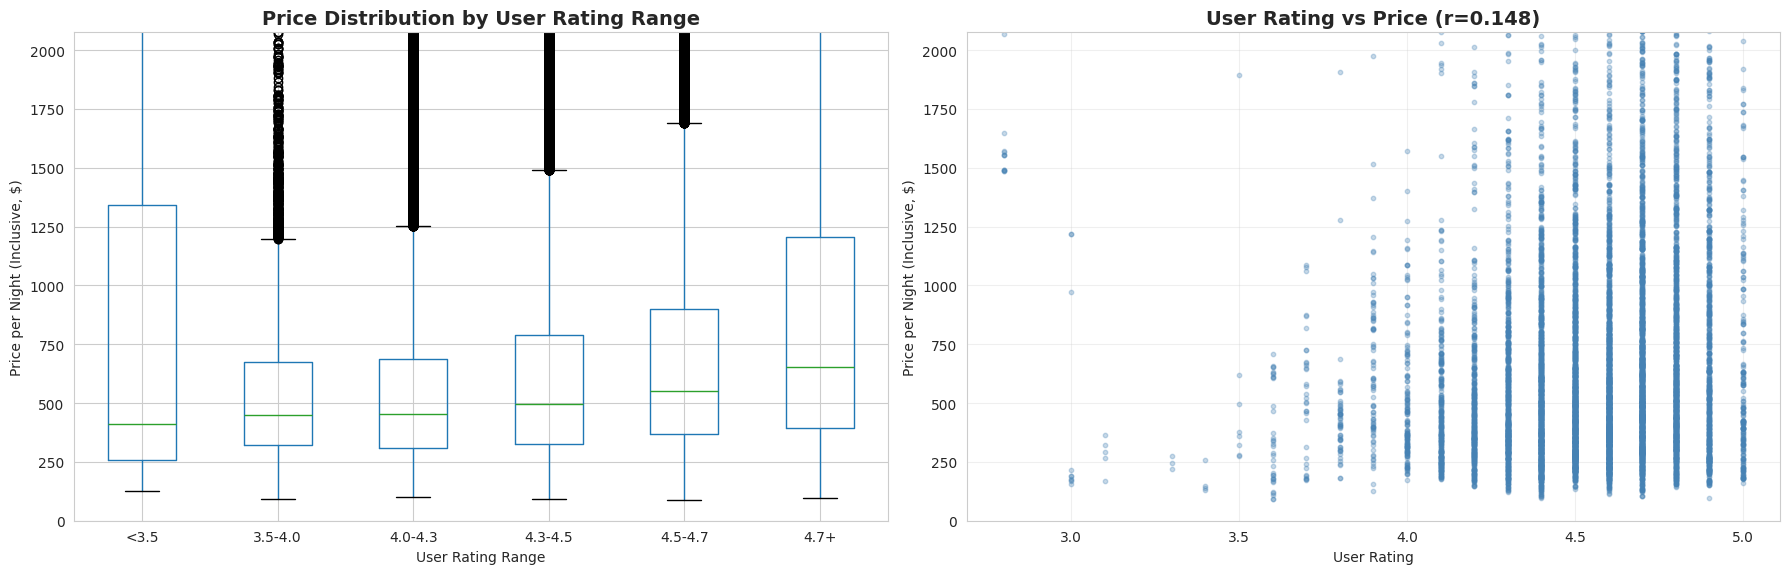

In [6]:
# Analyze user rating vs price relationship
user_rating_analysis = rates_df[rates_df['user_rating'].notna()].copy()

# Group by user rating bins
user_rating_analysis['rating_bin'] = pd.cut(user_rating_analysis['user_rating'], 
                                              bins=[0, 3.5, 4.0, 4.3, 4.5, 4.7, 5.0],
                                              labels=['<3.5', '3.5-4.0', '4.0-4.3', '4.3-4.5', '4.5-4.7', '4.7+'])

rating_price_stats = user_rating_analysis.groupby('rating_bin').agg({
    'price_per_night_inclusive': ['mean', 'median', 'count'],
    'user_rating': 'mean'
}).round(2)

print("\n⭐ USER RATING vs PRICE ANALYSIS:")
print("="*80)
print(rating_price_stats)

# Calculate correlation
correlation = rates_df[['user_rating', 'price_per_night_inclusive']].corr().iloc[0, 1]
print(f"\nCorrelation between user rating and price: {correlation:.3f}")
if abs(correlation) < 0.3:
    print("⚠️  WEAK correlation - user rating may not be a strong value indicator")
elif abs(correlation) < 0.7:
    print("✓ MODERATE correlation - user rating has some relationship to price")
else:
    print("✓ STRONG correlation - user rating strongly related to price")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Box plot by rating bin
user_rating_analysis.boxplot(column='price_per_night_inclusive', by='rating_bin', ax=axes[0])
axes[0].set_title('Price Distribution by User Rating Range', fontsize=14, fontweight='bold')
axes[0].set_xlabel('User Rating Range')
axes[0].set_ylabel('Price per Night (Inclusive, $)')
axes[0].set_ylim(0, user_rating_analysis['price_per_night_inclusive'].quantile(0.95))
plt.suptitle('')  # Remove default title

# Scatter plot (sample for performance)
sample = user_rating_analysis.sample(min(10000, len(user_rating_analysis)))
axes[1].scatter(sample['user_rating'], sample['price_per_night_inclusive'], 
                alpha=0.3, s=10, c='steelblue')
axes[1].set_title(f'User Rating vs Price (r={correlation:.3f})', fontsize=14, fontweight='bold')
axes[1].set_xlabel('User Rating')
axes[1].set_ylabel('Price per Night (Inclusive, $)')
axes[1].set_ylim(0, user_rating_analysis['price_per_night_inclusive'].quantile(0.95))
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Validate: Are Amenities Meaningful Differentiators?


🎁 AMENITY ANALYSIS BY COLLECTION TYPE:
                    FHR   THC
Breakfast          16.1   5.3
F&B Credit          0.0   0.3
Free Cancellation  81.5  86.5
Parking            40.1  22.9
Shuttle             0.1   0.0

⚠️  Note: FHR properties ALWAYS include breakfast by default (plus late checkout, early checkin, upgrades)
    Therefore, breakfast is only a value differentiator for THC properties.


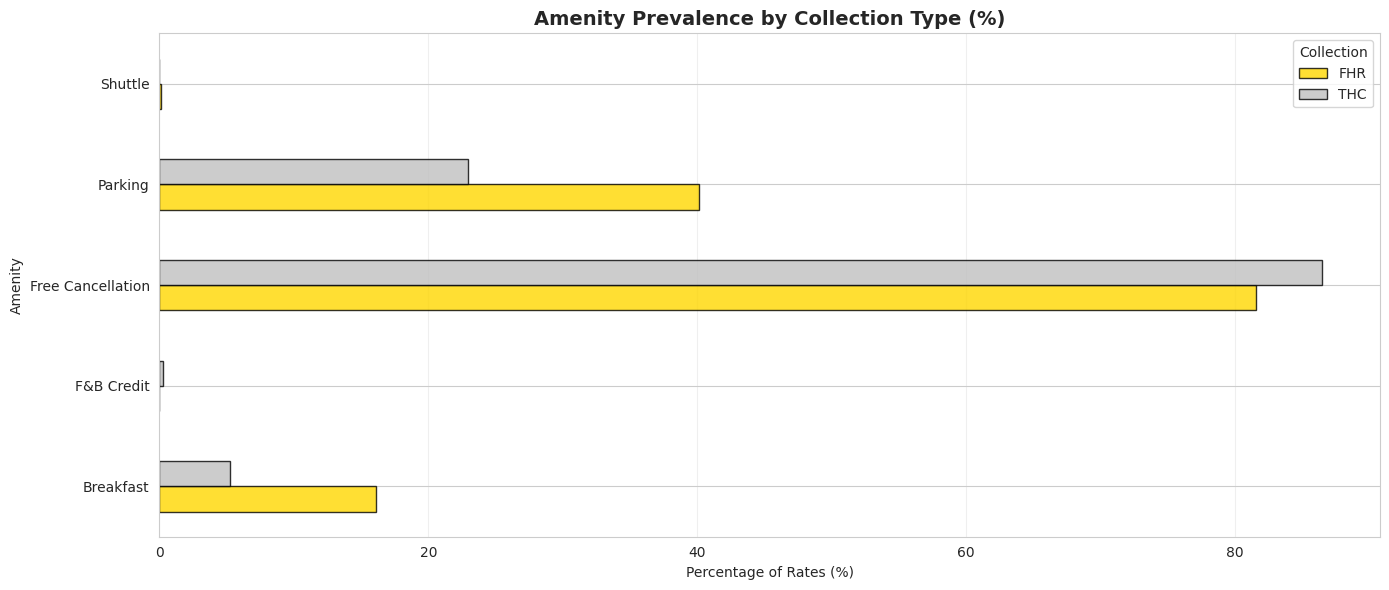


THC: Price with/without Breakfast:
                             mean  median   count
is_breakfast_included                            
0                      460.040597  380.35  223952
1                      679.049037  527.89   12425

Average price premium for breakfast in THC: $219.01/night


In [7]:
# Analyze amenities by collection type (remember: FHR always has breakfast!)
amenity_by_collection = pd.DataFrame({
    'FHR': [
        rates_df[rates_df['collection_type']=='FHR']['is_breakfast_included'].mean() * 100,
        rates_df[rates_df['collection_type']=='FHR']['is_food_beverage_credit'].mean() * 100,
        rates_df[rates_df['collection_type']=='FHR']['is_free_cancellation'].mean() * 100,
        rates_df[rates_df['collection_type']=='FHR']['is_parking_included'].mean() * 100,
        rates_df[rates_df['collection_type']=='FHR']['is_shuttle_included'].mean() * 100,
    ],
    'THC': [
        rates_df[rates_df['collection_type']=='THC']['is_breakfast_included'].mean() * 100,
        rates_df[rates_df['collection_type']=='THC']['is_food_beverage_credit'].mean() * 100,
        rates_df[rates_df['collection_type']=='THC']['is_free_cancellation'].mean() * 100,
        rates_df[rates_df['collection_type']=='THC']['is_parking_included'].mean() * 100,
        rates_df[rates_df['collection_type']=='THC']['is_shuttle_included'].mean() * 100,
    ]
}, index=['Breakfast', 'F&B Credit', 'Free Cancellation', 'Parking', 'Shuttle'])

print("\n🎁 AMENITY ANALYSIS BY COLLECTION TYPE:")
print("="*80)
print(amenity_by_collection.round(1))
print("\n⚠️  Note: FHR properties ALWAYS include breakfast by default (plus late checkout, early checkin, upgrades)")
print("    Therefore, breakfast is only a value differentiator for THC properties.")

# Visualize
amenity_by_collection.plot(kind='barh', figsize=(14, 6), 
                            color=['gold', 'silver'], 
                            alpha=0.8, edgecolor='black')
plt.title('Amenity Prevalence by Collection Type (%)', fontsize=14, fontweight='bold')
plt.xlabel('Percentage of Rates (%)')
plt.ylabel('Amenity')
plt.legend(title='Collection')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Analyze price difference with/without breakfast for THC
thc_rates = rates_df[rates_df['collection_type'] == 'THC'].copy()
if len(thc_rates) > 0:
    thc_breakfast_price = thc_rates.groupby('is_breakfast_included')['price_per_night_inclusive'].agg(['mean', 'median', 'count'])
    print("\nTHC: Price with/without Breakfast:")
    print(thc_breakfast_price)
    if 0 in thc_breakfast_price.index and 1 in thc_breakfast_price.index:
        price_diff = thc_breakfast_price.loc[1, 'mean'] - thc_breakfast_price.loc[0, 'mean']
        print(f"\nAverage price premium for breakfast in THC: ${price_diff:.2f}/night")

## 7. Star Rating Analysis - Validate Limited Usefulness


⭐ STAR RATING DISTRIBUTION:
star_rating
0.0      7248
2.0       178
2.5       189
3.0       692
3.5      3440
4.0     98493
4.5     64881
5.0    390472
Name: count, dtype: int64

Percentage 4+ stars: 97.9%
Percentage 5 stars: 69.0%


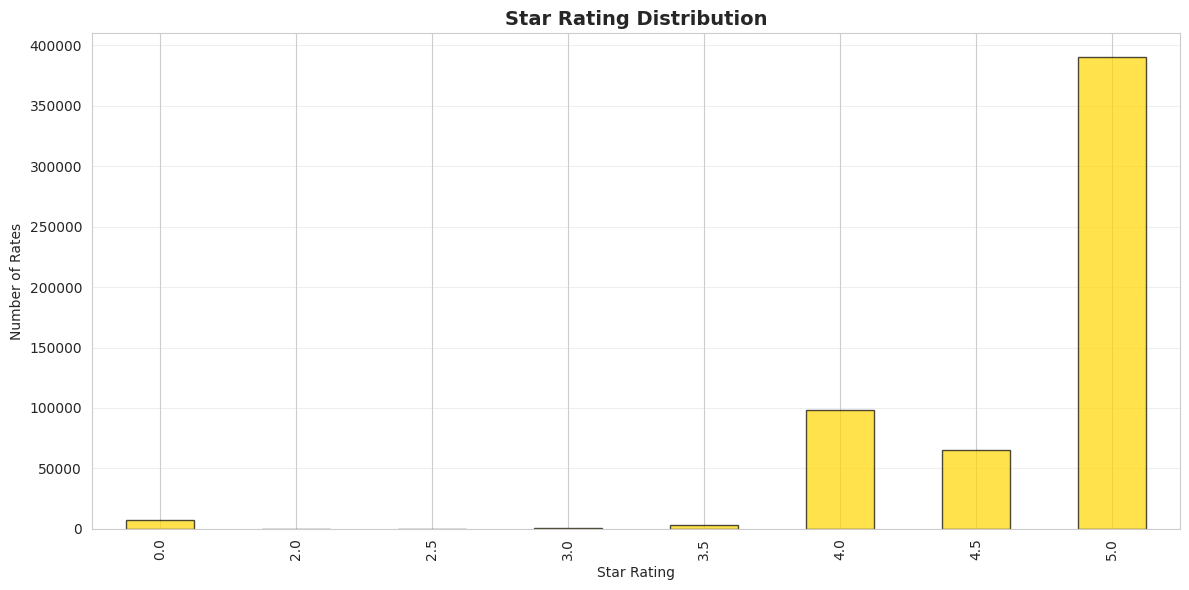


⚠️  CONCLUSION: Star rating has limited usefulness - over 80% are 4+ stars


In [8]:
# Confirm that most properties are 4-5 star
star_distribution = rates_df['star_rating'].value_counts().sort_index()

print("\n⭐ STAR RATING DISTRIBUTION:")
print("="*80)
print(star_distribution)
print(f"\nPercentage 4+ stars: {(rates_df['star_rating'] >= 4).sum() / len(rates_df) * 100:.1f}%")
print(f"Percentage 5 stars: {(rates_df['star_rating'] == 5).sum() / len(rates_df) * 100:.1f}%")

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
star_distribution.plot(kind='bar', ax=ax, color='gold', alpha=0.7, edgecolor='black')
ax.set_title('Star Rating Distribution', fontsize=14, fontweight='bold')
ax.set_xlabel('Star Rating')
ax.set_ylabel('Number of Rates')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

if (rates_df['star_rating'] >= 4).sum() / len(rates_df) > 0.8:
    print("\n⚠️  CONCLUSION: Star rating has limited usefulness - over 80% are 4+ stars")

## 8. 📅 TEMPORAL ANALYSIS - DEEP DIVE

**This is the most valuable section - analyzing price patterns within our complete dataset!**

In [9]:
# Comprehensive temporal analysis
temporal_df = rates_df.groupby(rates_df['check_in'].dt.date).agg({
    'snapshot_id': 'count',
    'price_per_night_inclusive': ['mean', 'median', 'min', 'std'],
    'property_id': 'nunique',
    'destination_name': 'nunique'
}).round(2)

temporal_df.columns = ['rate_count', 'avg_price', 'median_price', 'min_price', 'price_std', 'unique_hotels', 'unique_destinations']
temporal_df.index = pd.to_datetime(temporal_df.index)

# Add day of week
temporal_df['day_of_week'] = temporal_df.index.dayofweek
temporal_df['day_name'] = temporal_df.index.day_name()

# Add week number and month
temporal_df['week'] = temporal_df.index.isocalendar().week
temporal_df['month'] = temporal_df.index.month
temporal_df['month_name'] = temporal_df.index.month_name()

print("\n📅 TEMPORAL PRICE ANALYSIS (COMPLETE DATASET):")
print("="*80)
print(f"Date range: {temporal_df.index.min()} to {temporal_df.index.max()}")
print(f"Total days covered: {len(temporal_df)}")
print(f"\nOverall Statistics:")
print(f"  Average price/night: ${temporal_df['avg_price'].mean():.2f}")
print(f"  Median price/night: ${temporal_df['median_price'].mean():.2f}")
print(f"  Lowest average: ${temporal_df['avg_price'].min():.2f} on {temporal_df['avg_price'].idxmin().strftime('%Y-%m-%d')}")
print(f"  Highest average: ${temporal_df['avg_price'].max():.2f} on {temporal_df['avg_price'].idxmax().strftime('%Y-%m-%d')}")
print(f"  Price range: ${temporal_df['avg_price'].max() - temporal_df['avg_price'].min():.2f}")

display(temporal_df.head(10))


📅 TEMPORAL PRICE ANALYSIS (COMPLETE DATASET):
Date range: 2025-11-14 00:00:00 to 2026-02-23 00:00:00
Total days covered: 102

Overall Statistics:
  Average price/night: $848.01
  Median price/night: $554.11
  Lowest average: $706.24 on 2025-12-14
  Highest average: $1085.31 on 2025-12-30
  Price range: $379.07


,rate_count,avg_price,median_price,min_price,price_std,unique_hotels,unique_destinations,day_of_week,day_name,week,month,month_name
check_in,,,,,,,,,,,,
2025-11-14,13690,884.72,552.14,98.28,1338.45,2354,163,4,Friday,46,11,November
2025-11-15,12525,844.57,545.29,97.90,1265.09,2353,165,5,Saturday,46,11,November
2025-11-16,5156,879.49,560.40,97.53,1499.11,2342,165,6,Sunday,46,11,November
2025-11-17,5042,895.12,576.84,97.53,1385.82,2297,166,0,Monday,47,11,November
2025-11-18,5001,902.39,588.00,93.27,1432.51,2278,165,1,Tuesday,47,11,November
2025-11-19,5099,876.75,576.60,97.53,1349.20,2305,164,2,Wednesday,47,11,November
2025-11-20,5168,887.57,569.62,99.42,1401.88,2341,165,3,Thursday,47,11,November
2025-11-21,5228,854.05,546.72,99.42,1332.61,2366,165,4,Friday,47,11,November
2025-11-22,5256,847.22,529.78,97.53,1439.03,2381,165,5,Saturday,47,11,November


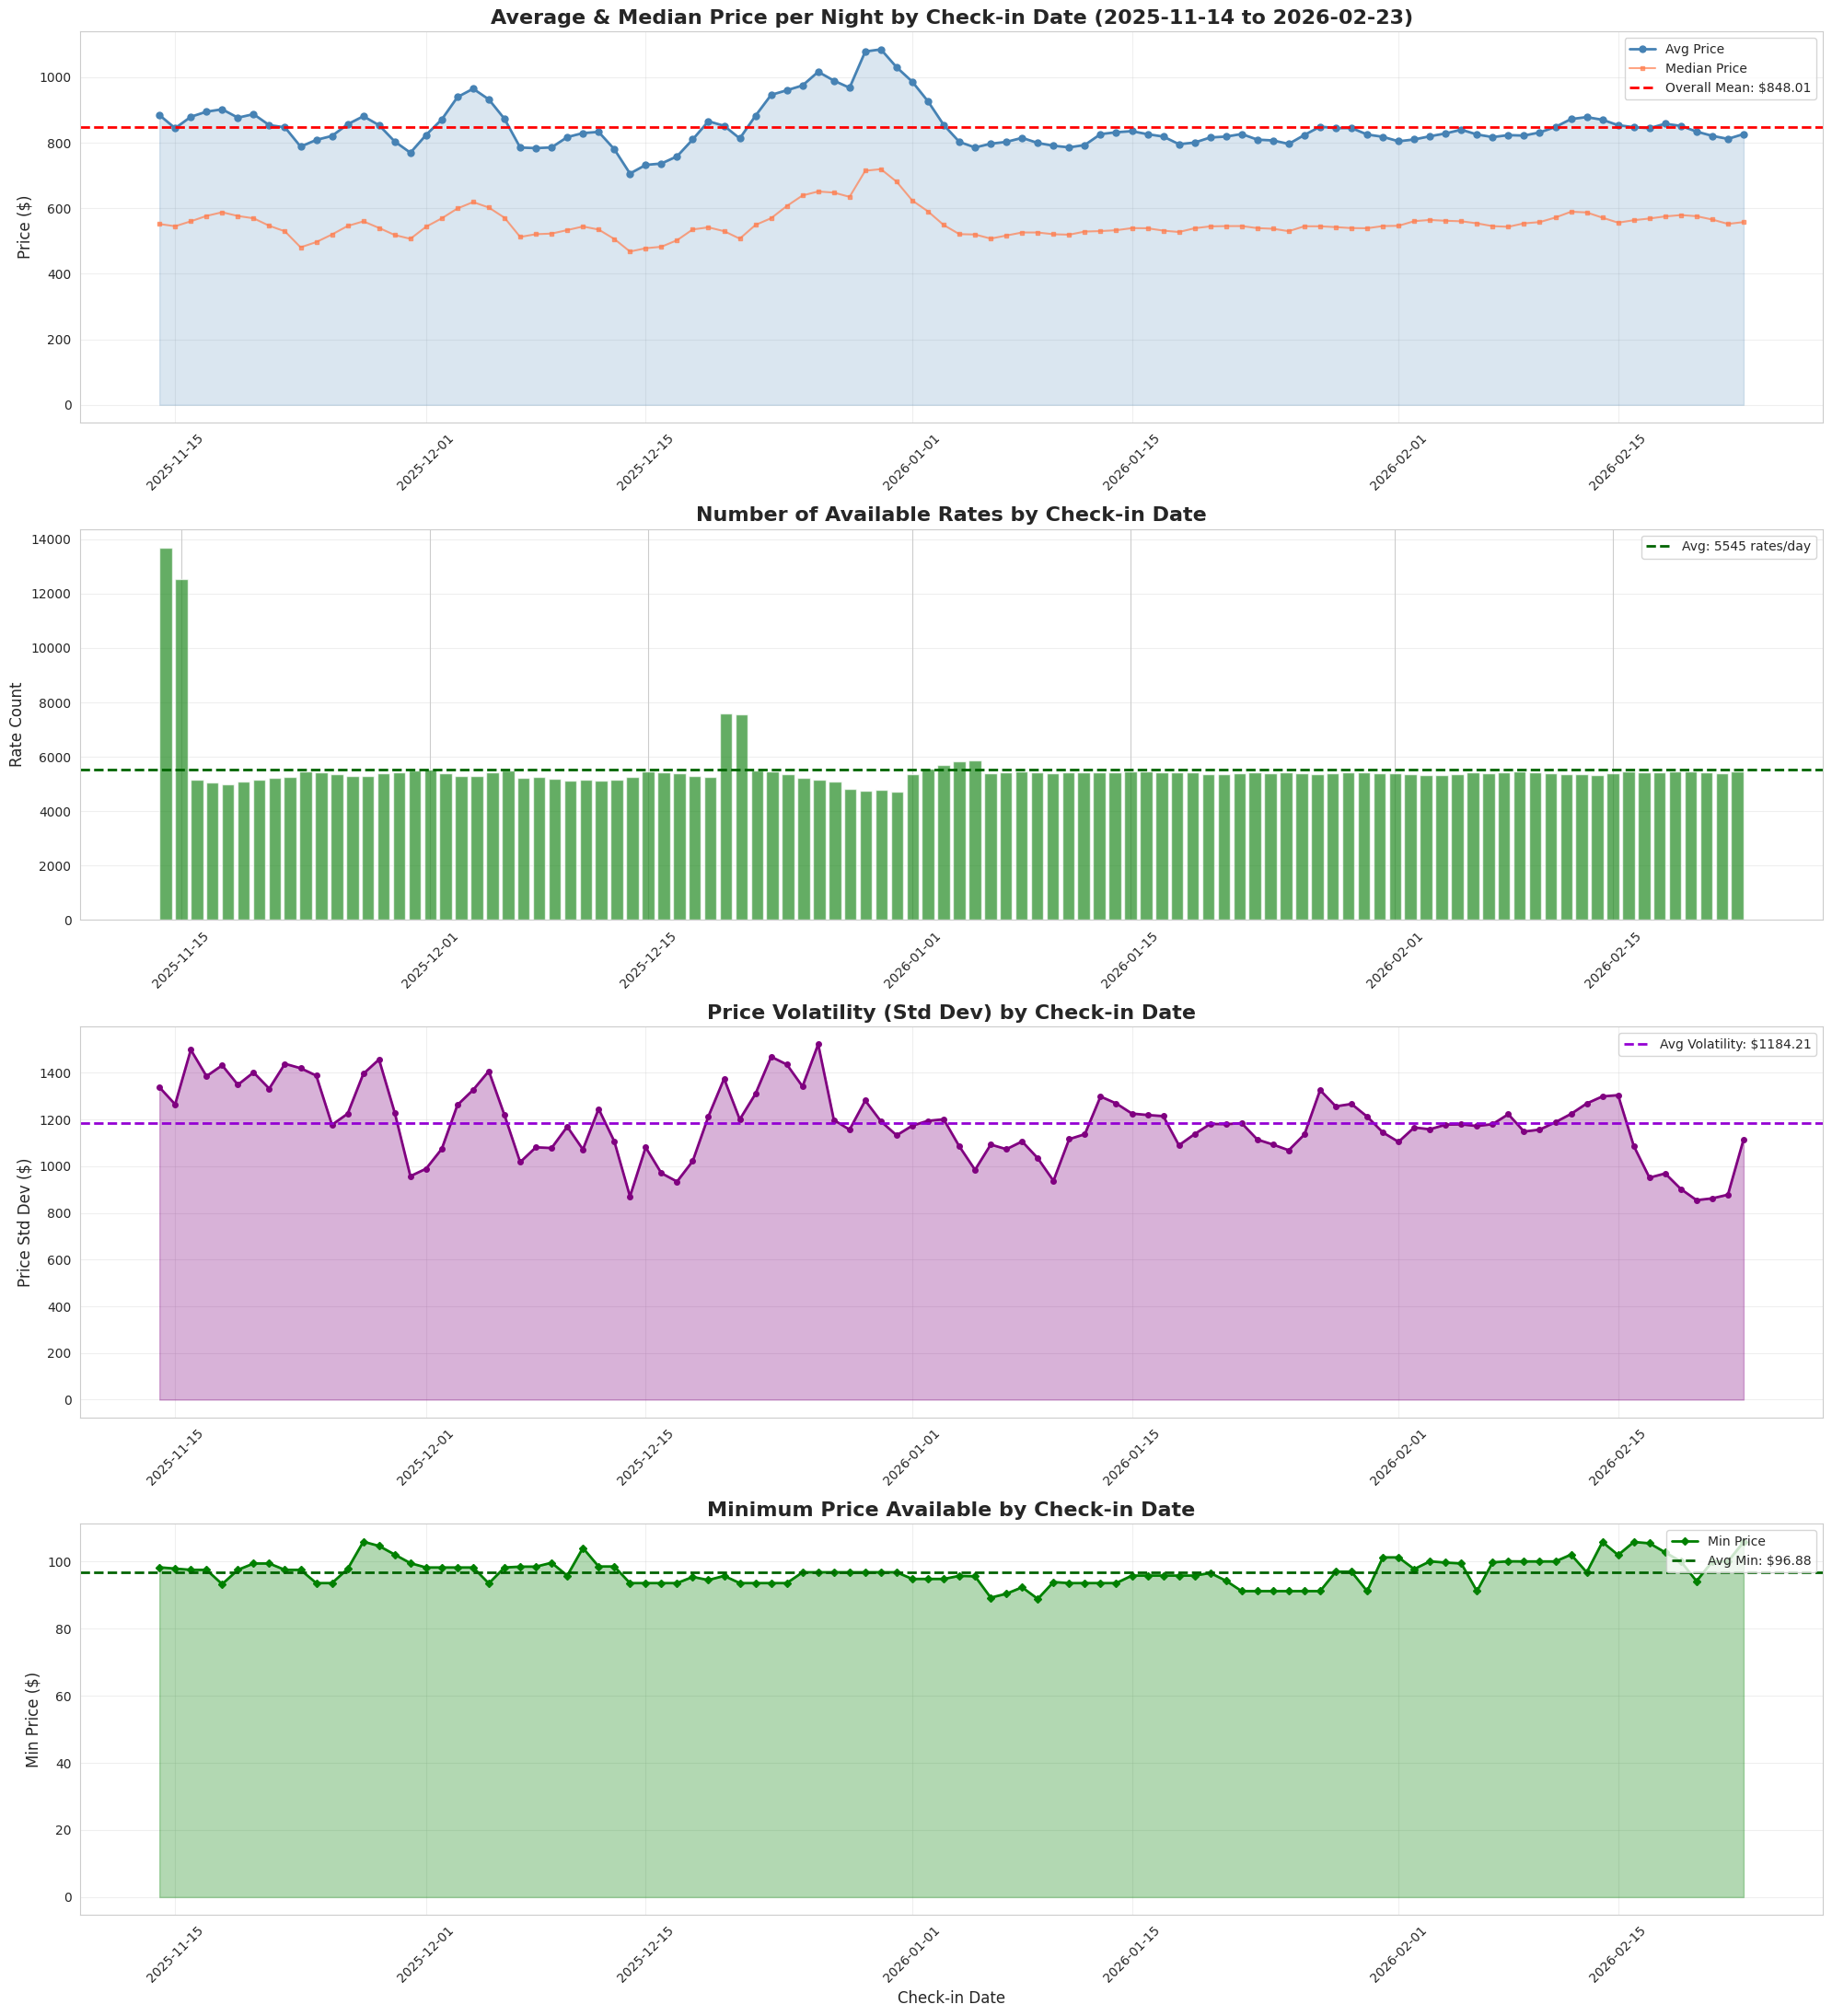

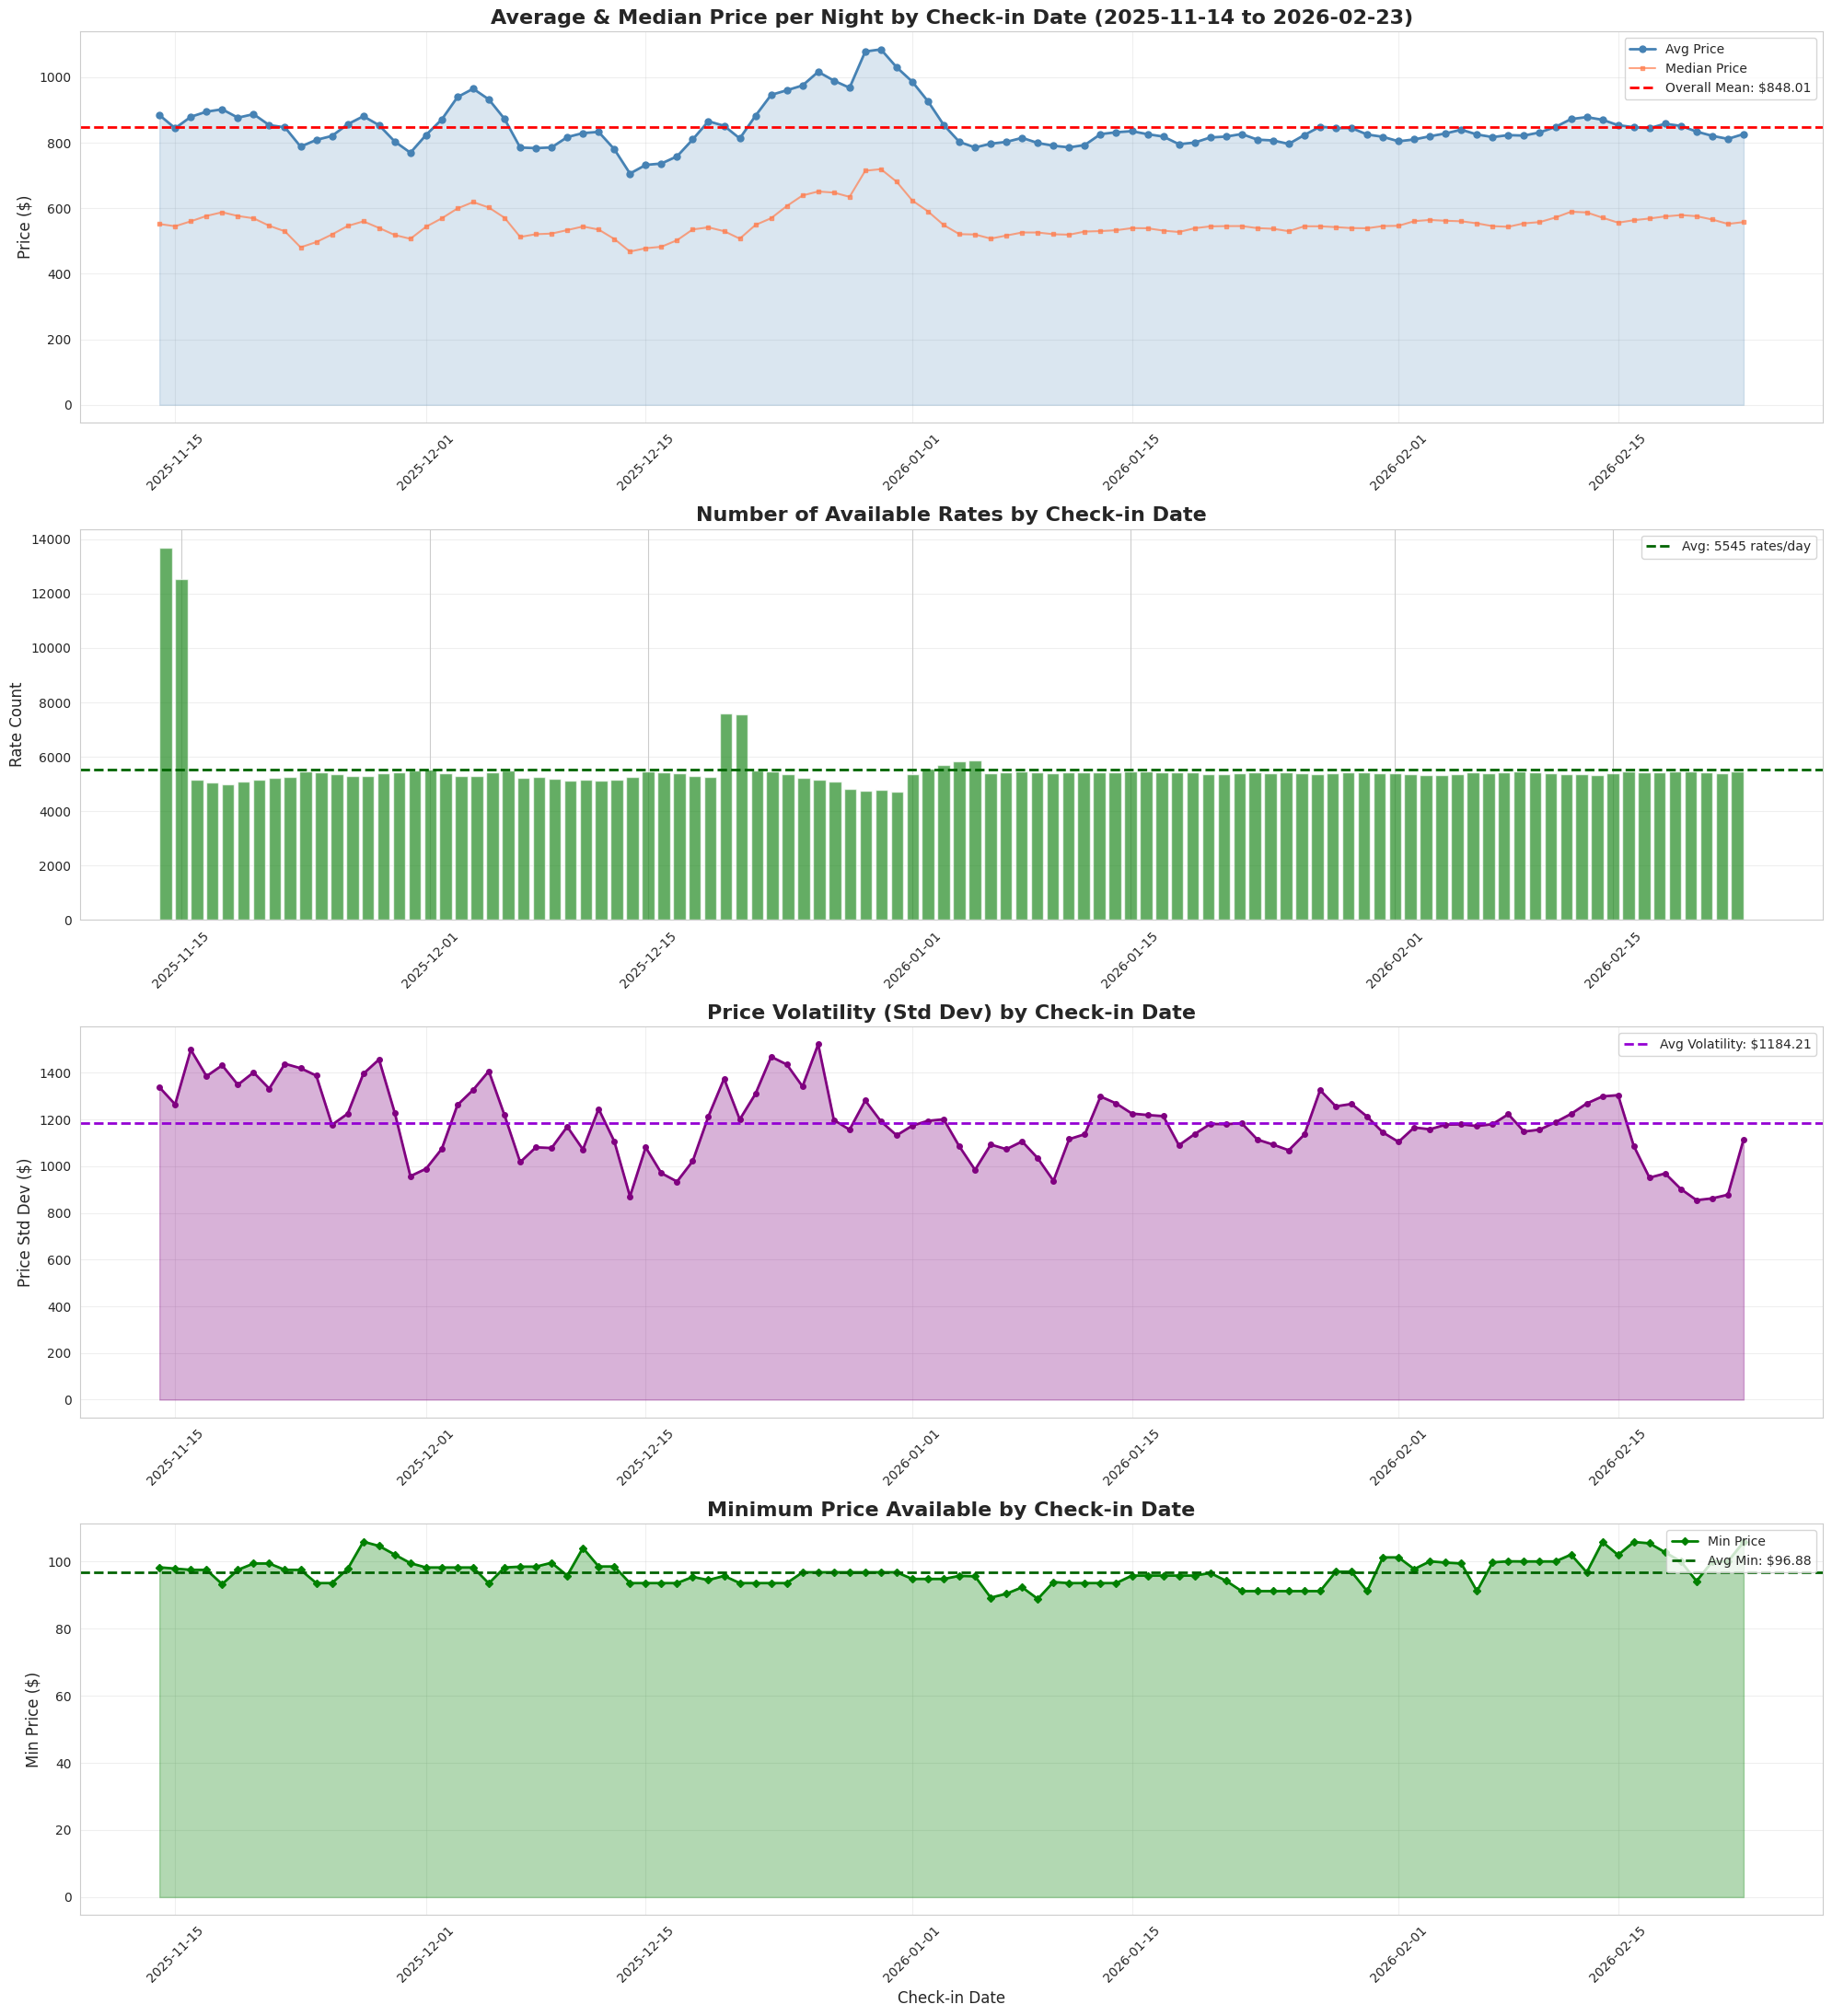

In [28]:
# Comprehensive time-based visualization
fig, axes = plt.subplots(4, 1, figsize=(20, 22))

# 1. Average price over time with trend
axes[0].plot(temporal_df.index, temporal_df['avg_price'], marker='o', linewidth=2, 
             color='steelblue', label='Avg Price', markersize=5)
axes[0].plot(temporal_df.index, temporal_df['median_price'], marker='s', linewidth=1.5, 
             color='coral', alpha=0.7, label='Median Price', markersize=3)
axes[0].fill_between(temporal_df.index, temporal_df['avg_price'], alpha=0.2, color='steelblue')
axes[0].axhline(temporal_df['avg_price'].mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Overall Mean: ${temporal_df["avg_price"].mean():.2f}')
axes[0].set_title(f'Average & Median Price per Night by Check-in Date ({START_DATE} to {END_DATE})', 
                  fontsize=16, fontweight='bold')
axes[0].set_ylabel('Price ($)', fontsize=12)
axes[0].legend(loc='upper right', fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# 2. Number of available rates
axes[1].bar(temporal_df.index, temporal_df['rate_count'], alpha=0.7, color='forestgreen', width=0.8)
axes[1].axhline(temporal_df['rate_count'].mean(), color='darkgreen', linestyle='--', linewidth=2,
                label=f'Avg: {temporal_df["rate_count"].mean():.0f} rates/day')
axes[1].set_title('Number of Available Rates by Check-in Date', fontsize=16, fontweight='bold')
axes[1].set_ylabel('Rate Count', fontsize=12)
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].tick_params(axis='x', rotation=45)

# 3. Price volatility (std dev)
axes[2].plot(temporal_df.index, temporal_df['price_std'], marker='o', linewidth=2, 
             color='purple', markersize=4)
axes[2].fill_between(temporal_df.index, temporal_df['price_std'], alpha=0.3, color='purple')
axes[2].axhline(temporal_df['price_std'].mean(), color='darkviolet', linestyle='--', linewidth=2,
                label=f'Avg Volatility: ${temporal_df["price_std"].mean():.2f}')
axes[2].set_title('Price Volatility (Std Dev) by Check-in Date', fontsize=16, fontweight='bold')
axes[2].set_ylabel('Price Std Dev ($)', fontsize=12)
axes[2].legend(loc='upper right')
axes[2].grid(True, alpha=0.3)
axes[2].tick_params(axis='x', rotation=45)

# 4. Minimum price available
axes[3].plot(temporal_df.index, temporal_df['min_price'], marker='D', linewidth=2, 
             color='green', markersize=4, label='Min Price')
axes[3].fill_between(temporal_df.index, temporal_df['min_price'], alpha=0.3, color='green')
axes[3].axhline(temporal_df['min_price'].mean(), color='darkgreen', linestyle='--', linewidth=2,
                label=f'Avg Min: ${temporal_df["min_price"].mean():.2f}')
axes[3].set_title('Minimum Price Available by Check-in Date', fontsize=16, fontweight='bold')
axes[3].set_ylabel('Min Price ($)', fontsize=12)
axes[3].set_xlabel('Check-in Date', fontsize=12)
axes[3].legend(loc='upper right')
axes[3].grid(True, alpha=0.3)
axes[3].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


📊 DAY OF WEEK ANALYSIS:
          avg_price        rate_count min_price
               mean    std        sum      mean
day_name                                       
Monday       834.46  78.24      80828     97.16
Tuesday      852.56  83.78      74429     96.06
Wednesday    862.48  70.66      74006     96.50
Thursday     873.09  60.19      74738     98.04
Friday       864.50  57.44      88826     95.31
Saturday     839.42  49.97      90029     97.96
Sunday       812.46  57.52      82737     97.11


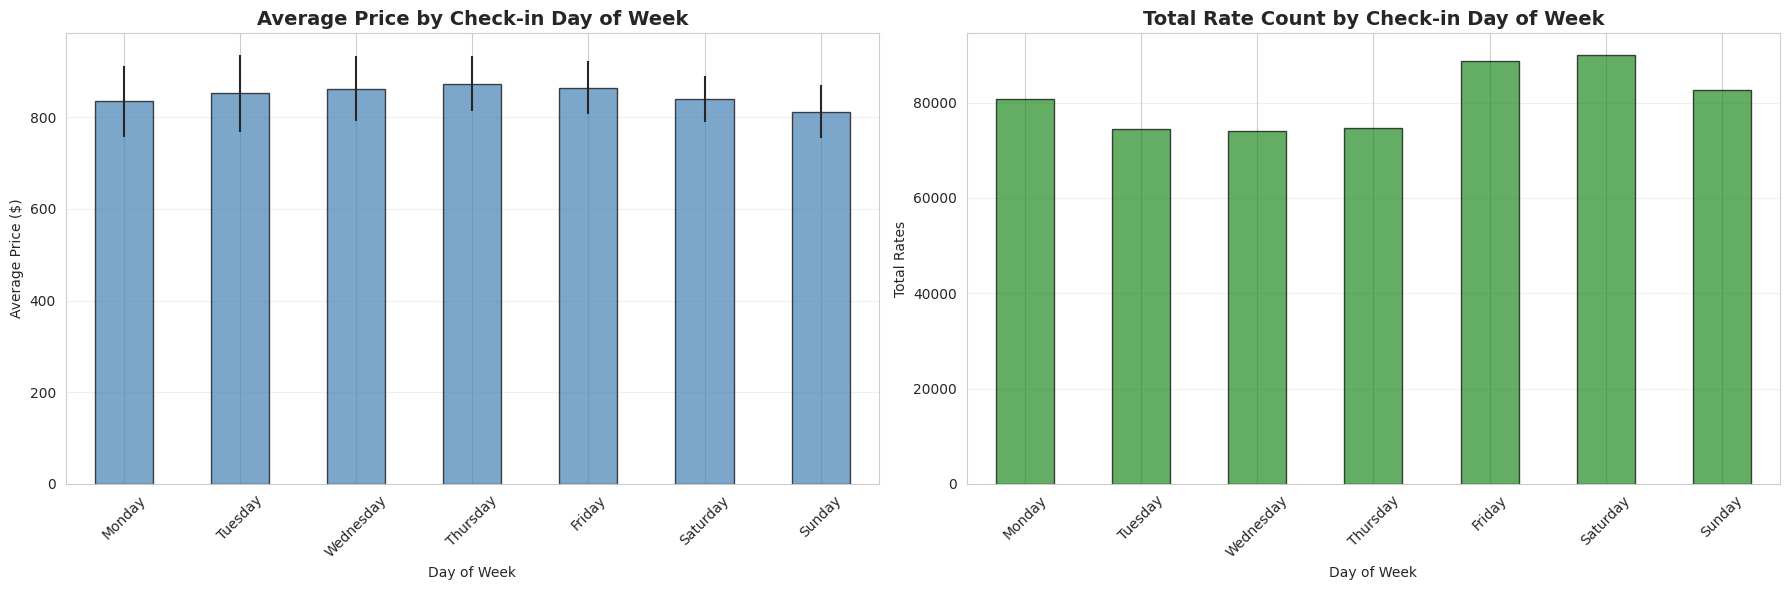


💡 KEY INSIGHTS:
   Cheapest check-in day: Sunday ($812.46)
   Most expensive check-in day: Thursday ($873.09)
   Potential savings: $60.63/night by choosing Sunday over Thursday


In [29]:
# Day of week analysis
dow_analysis = temporal_df.groupby('day_name').agg({
    'avg_price': ['mean', 'std'],
    'rate_count': 'sum',
    'min_price': 'mean'
}).round(2)

# Reorder by day of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_analysis = dow_analysis.reindex([d for d in day_order if d in dow_analysis.index])

print("\n📊 DAY OF WEEK ANALYSIS:")
print("="*80)
print(dow_analysis)

# Visualize day of week patterns
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Average price by day
dow_analysis[('avg_price', 'mean')].plot(kind='bar', ax=axes[0], color='steelblue', 
                                           alpha=0.7, edgecolor='black', yerr=dow_analysis[('avg_price', 'std')])
axes[0].set_title('Average Price by Check-in Day of Week', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Average Price ($)')
axes[0].set_xlabel('Day of Week')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')

# Rate availability by day
dow_analysis[('rate_count', 'sum')].plot(kind='bar', ax=axes[1], color='forestgreen', 
                                          alpha=0.7, edgecolor='black')
axes[1].set_title('Total Rate Count by Check-in Day of Week', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Total Rates')
axes[1].set_xlabel('Day of Week')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Find best day of week
best_day = dow_analysis[('avg_price', 'mean')].idxmin()
worst_day = dow_analysis[('avg_price', 'mean')].idxmax()
savings = dow_analysis.loc[worst_day, ('avg_price', 'mean')] - dow_analysis.loc[best_day, ('avg_price', 'mean')]

print(f"\n💡 KEY INSIGHTS:")
print(f"   Cheapest check-in day: {best_day} (${dow_analysis.loc[best_day, ('avg_price', 'mean')]:.2f})")
print(f"   Most expensive check-in day: {worst_day} (${dow_analysis.loc[worst_day, ('avg_price', 'mean')]:.2f})")
print(f"   Potential savings: ${savings:.2f}/night by choosing {best_day} over {worst_day}")

In [30]:
# Top 10 best value dates (lowest average price)
best_dates = temporal_df.nsmallest(10, 'avg_price')[['avg_price', 'median_price', 'min_price', 
                                                        'rate_count', 'unique_hotels', 'day_name']]

print("\n🏆 TOP 10 BEST VALUE CHECK-IN DATES (Lowest Avg Price):")
print("="*100)
display(best_dates)

# Top 10 dates with most options
most_options = temporal_df.nlargest(10, 'rate_count')[['rate_count', 'avg_price', 'median_price', 
                                                         'unique_hotels', 'unique_destinations', 'day_name']]

print("\n🏆 TOP 10 DATES WITH MOST OPTIONS:")
print("="*100)
display(most_options)

# Dates with best min prices (absolute cheapest options)
best_min_prices = temporal_df.nsmallest(10, 'min_price')[['min_price', 'avg_price', 'rate_count', 
                                                            'unique_hotels', 'day_name']]

print("\n🏆 TOP 10 DATES WITH LOWEST MINIMUM PRICE:")
print("="*100)
display(best_min_prices)


🏆 TOP 10 BEST VALUE CHECK-IN DATES (Lowest Avg Price):


,avg_price,median_price,min_price,rate_count,unique_hotels,day_name
check_in,,,,,,
2025-12-14,706.24,468.06,93.58,5257,2550,Sunday
2025-12-15,732.54,478.10,93.58,5452,2542,Monday
2025-12-16,736.79,482.65,93.58,5435,2534,Tuesday
2025-12-17,758.68,502.59,93.58,5384,2516,Wednesday
2025-11-30,769.84,506.90,99.52,5484,2464,Sunday
2025-12-13,780.56,506.36,98.53,5164,2508,Saturday
2025-12-08,783.84,521.05,98.48,5248,2479,Monday
2025-12-07,785.62,512.60,98.48,5240,2477,Sunday
2026-01-05,785.85,520.08,95.61,5860,2435,Monday



🏆 TOP 10 DATES WITH MOST OPTIONS:


,rate_count,avg_price,median_price,unique_hotels,unique_destinations,day_name
check_in,,,,,,
2025-11-14,13690,884.72,552.14,2354,163,Friday
2025-11-15,12525,844.57,545.29,2353,165,Saturday
2025-12-20,7584,851.87,530.19,2454,157,Saturday
2025-12-21,7574,813.45,507.38,2437,156,Sunday
2026-01-05,5860,785.85,520.08,2435,164,Monday
2026-01-04,5834,802.81,521.13,2426,163,Sunday
2026-01-03,5691,854.85,549.08,2373,159,Saturday
2026-01-02,5575,926.76,590.60,2333,157,Friday
2025-12-01,5545,824.12,543.79,2417,163,Monday



🏆 TOP 10 DATES WITH LOWEST MINIMUM PRICE:


,min_price,avg_price,rate_count,unique_hotels,day_name
check_in,,,,,
2026-01-09,88.87,799.52,5436,2436,Friday
2026-01-06,89.25,797.34,5412,2433,Tuesday
2026-01-07,90.41,802.89,5423,2431,Wednesday
2026-01-22,91.19,826.89,5399,2429,Thursday
2026-01-23,91.19,809.72,5432,2448,Friday
2026-01-24,91.19,807.30,5401,2429,Saturday
2026-01-25,91.19,796.70,5437,2443,Sunday
2026-01-26,91.19,824.07,5412,2434,Monday
2026-01-27,91.19,849.40,5374,2422,Tuesday


## 9. Temporal Analysis by Destination


📍 PRICE TRENDS FOR TOP 8 DESTINATIONS:


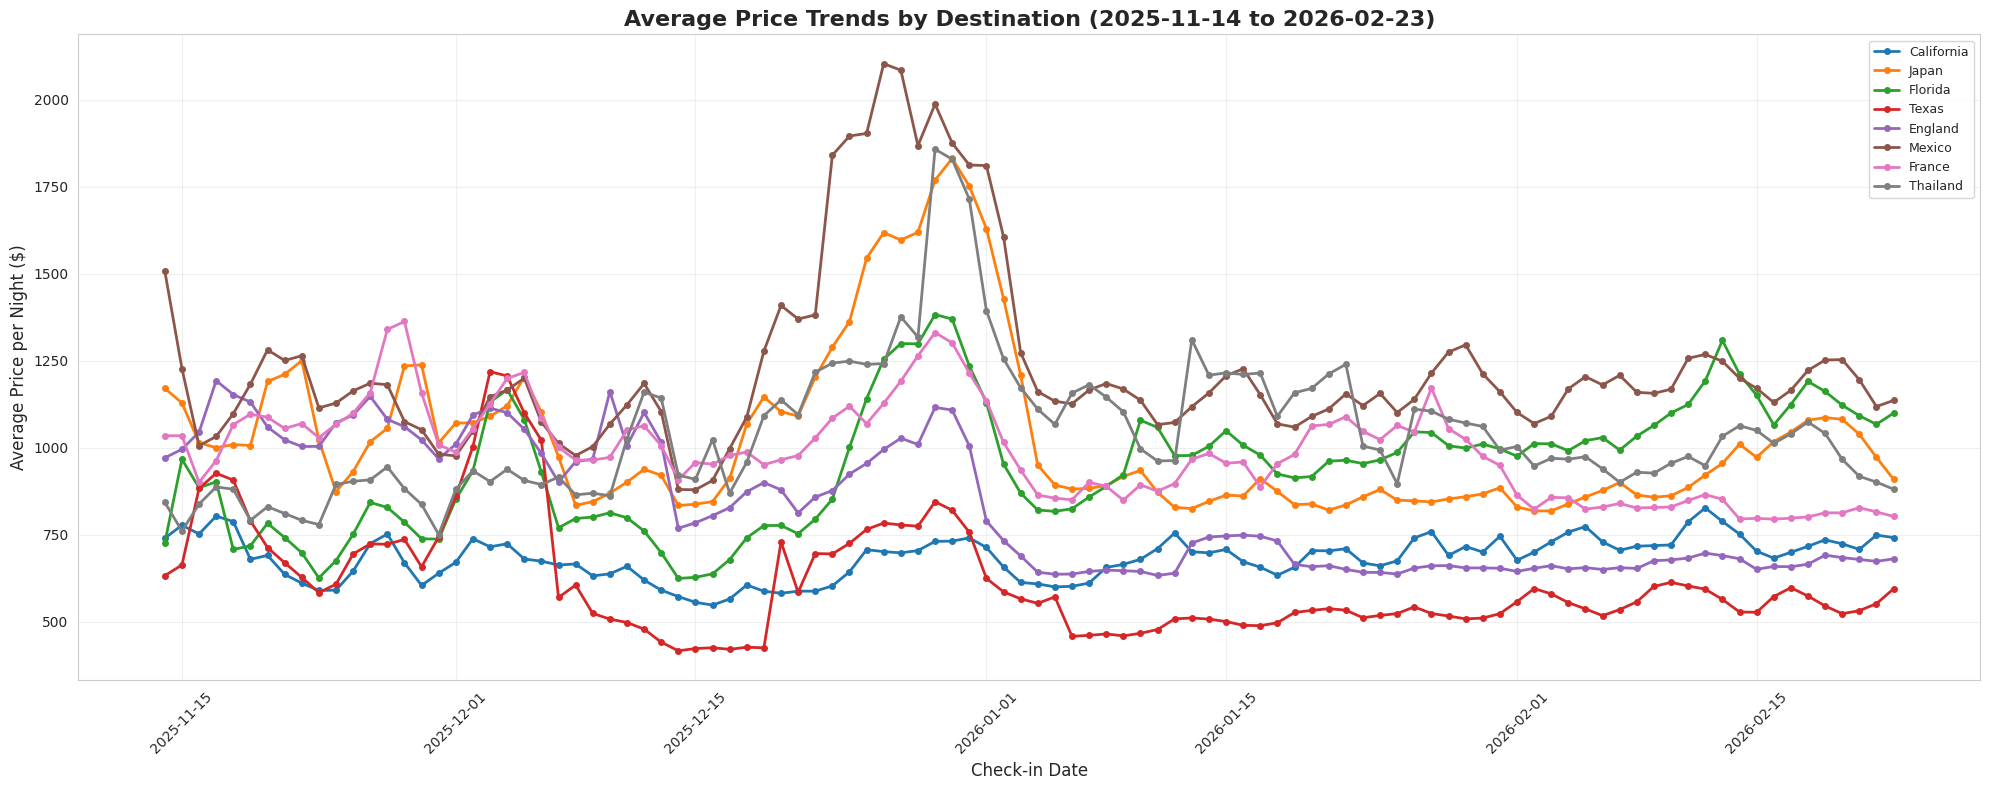


💎 BEST CHECK-IN DATE FOR EACH TOP DESTINATION:

California:
  💰 Best date: 2025-12-16 - $547.73/night (358 rates)
  💸 Worst date: 2026-02-12 - $827.11/night
  📊 Potential savings: $279.38/night

Japan:
  💰 Best date: 2026-02-03 - $818.39/night (416 rates)
  💸 Worst date: 2025-12-30 - $1831.65/night
  📊 Potential savings: $1013.26/night

Florida:
  💰 Best date: 2025-12-14 - $624.30/night (254 rates)
  💸 Worst date: 2025-12-29 - $1383.02/night
  📊 Potential savings: $758.72/night

Texas:
  💰 Best date: 2025-12-14 - $416.31/night (140 rates)
  💸 Worst date: 2025-12-03 - $1218.84/night
  📊 Potential savings: $802.52/night

England:
  💰 Best date: 2026-01-11 - $632.98/night (219 rates)
  💸 Worst date: 2025-11-17 - $1192.95/night
  📊 Potential savings: $559.98/night

Mexico:
  💰 Best date: 2025-12-15 - $879.34/night (220 rates)
  💸 Worst date: 2025-12-26 - $2104.22/night
  📊 Potential savings: $1224.88/night

France:
  💰 Best date: 2026-02-16 - $794.89/night (206 rates)
  💸 Worst date: 2025

In [31]:
# Price trends by destination
dest_temporal = rates_df.groupby(['destination_name', rates_df['check_in'].dt.date]).agg({
    'price_per_night_inclusive': 'mean',
    'snapshot_id': 'count'
}).reset_index()
dest_temporal.columns = ['destination', 'check_in', 'avg_price', 'rate_count']
dest_temporal['check_in'] = pd.to_datetime(dest_temporal['check_in'])

# Get top 8 destinations by rate count
top_destinations = rates_df['destination_name'].value_counts().head(8).index.tolist()

print(f"\n📍 PRICE TRENDS FOR TOP 8 DESTINATIONS:")
print("="*80)

# Plot price trends for top destinations
fig, ax = plt.subplots(figsize=(20, 8))

for dest in top_destinations:
    dest_data = dest_temporal[dest_temporal['destination'] == dest].sort_values('check_in')
    ax.plot(dest_data['check_in'], dest_data['avg_price'], marker='o', linewidth=2, 
            label=dest, markersize=4)

ax.set_title(f'Average Price Trends by Destination ({START_DATE} to {END_DATE})', 
             fontsize=16, fontweight='bold')
ax.set_xlabel('Check-in Date', fontsize=12)
ax.set_ylabel('Average Price per Night ($)', fontsize=12)
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Best dates for each top destination
print("\n💎 BEST CHECK-IN DATE FOR EACH TOP DESTINATION:")
print("="*80)
for dest in top_destinations:
    dest_data = dest_temporal[dest_temporal['destination'] == dest].sort_values('avg_price')
    if len(dest_data) > 0:
        best_date = dest_data.iloc[0]
        worst_date = dest_data.iloc[-1]
        savings = worst_date['avg_price'] - best_date['avg_price']
        print(f"\n{dest}:")
        print(f"  💰 Best date: {best_date['check_in'].strftime('%Y-%m-%d')} - ${best_date['avg_price']:.2f}/night ({best_date['rate_count']:.0f} rates)")
        print(f"  💸 Worst date: {worst_date['check_in'].strftime('%Y-%m-%d')} - ${worst_date['avg_price']:.2f}/night")
        print(f"  📊 Potential savings: ${savings:.2f}/night")

## 10. Temporal Analysis by Collection Type


🏨 PRICE TRENDS BY COLLECTION TYPE:


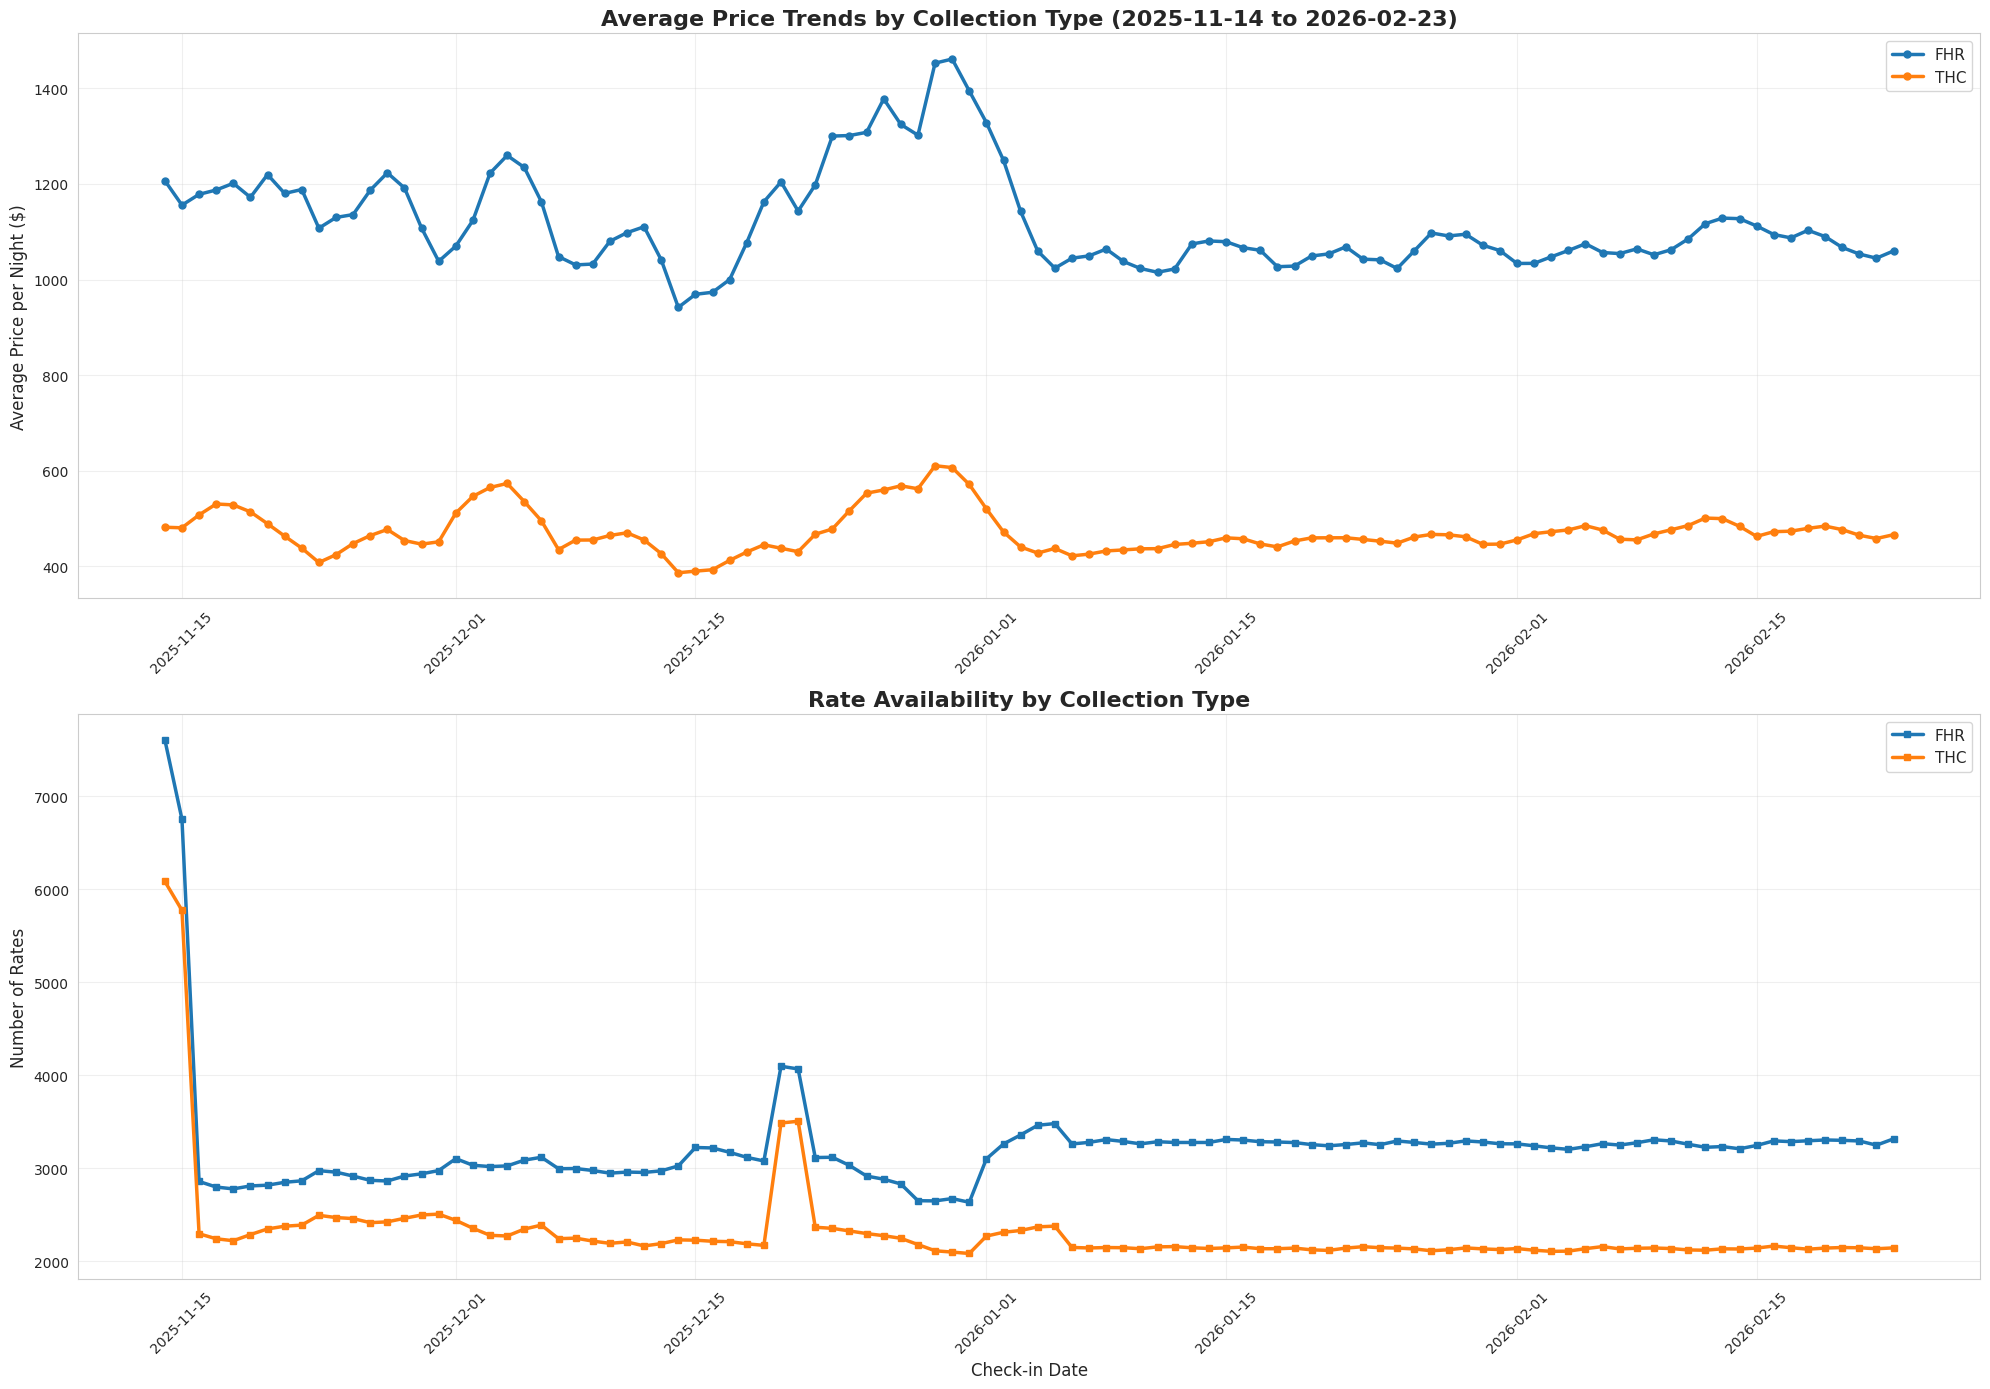


💰 FHR vs THC PRICING COMPARISON:

FHR:
  Average price: $1119.05/night
  Lowest average: $941.72 on 2025-12-14
  Highest average: $1461.01 on 2025-12-30
  Price range: $519.29

THC:
  Average price: $471.68/night
  Lowest average: $386.85 on 2025-12-14
  Highest average: $610.67 on 2025-12-29
  Price range: $223.81


In [32]:
# Price trends by collection type
collection_temporal = rates_df.groupby(['collection_type', rates_df['check_in'].dt.date]).agg({
    'price_per_night_inclusive': 'mean',
    'snapshot_id': 'count'
}).reset_index()
collection_temporal.columns = ['collection', 'check_in', 'avg_price', 'rate_count']
collection_temporal['check_in'] = pd.to_datetime(collection_temporal['check_in'])

print(f"\n🏨 PRICE TRENDS BY COLLECTION TYPE:")
print("="*80)

# Plot price trends by collection
fig, axes = plt.subplots(2, 1, figsize=(20, 14))

# Average price
for collection in ['FHR', 'THC']:
    coll_data = collection_temporal[collection_temporal['collection'] == collection].sort_values('check_in')
    if len(coll_data) > 0:
        axes[0].plot(coll_data['check_in'], coll_data['avg_price'], marker='o', linewidth=2.5, 
                    label=collection, markersize=5)

axes[0].set_title(f'Average Price Trends by Collection Type ({START_DATE} to {END_DATE})', 
                  fontsize=16, fontweight='bold')
axes[0].set_ylabel('Average Price per Night ($)', fontsize=12)
axes[0].legend(loc='best', fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Rate availability
for collection in ['FHR', 'THC']:
    coll_data = collection_temporal[collection_temporal['collection'] == collection].sort_values('check_in')
    if len(coll_data) > 0:
        axes[1].plot(coll_data['check_in'], coll_data['rate_count'], marker='s', linewidth=2.5, 
                    label=collection, markersize=4)

axes[1].set_title('Rate Availability by Collection Type', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Check-in Date', fontsize=12)
axes[1].set_ylabel('Number of Rates', fontsize=12)
axes[1].legend(loc='best', fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Compare FHR vs THC pricing
print("\n💰 FHR vs THC PRICING COMPARISON:")
print("="*80)
for collection in ['FHR', 'THC']:
    coll_data = collection_temporal[collection_temporal['collection'] == collection]
    if len(coll_data) > 0:
        print(f"\n{collection}:")
        print(f"  Average price: ${coll_data['avg_price'].mean():.2f}/night")
        print(f"  Lowest average: ${coll_data['avg_price'].min():.2f} on {coll_data.loc[coll_data['avg_price'].idxmin(), 'check_in'].strftime('%Y-%m-%d')}")
        print(f"  Highest average: ${coll_data['avg_price'].max():.2f} on {coll_data.loc[coll_data['avg_price'].idxmax(), 'check_in'].strftime('%Y-%m-%d')}")
        print(f"  Price range: ${coll_data['avg_price'].max() - coll_data['avg_price'].min():.2f}")

## 11. Export Temporal Insights

In [33]:
# Export temporal analysis
output_dir = Path('../data/exports')
output_dir.mkdir(parents=True, exist_ok=True)

# Export temporal summary
temporal_df.to_csv(output_dir / 'temporal_analysis_filtered.csv')
print(f"✅ Exported temporal analysis to: {output_dir / 'temporal_analysis_filtered.csv'}")

# Export day of week analysis
dow_analysis.to_csv(output_dir / 'day_of_week_analysis_filtered.csv')
print(f"✅ Exported day of week analysis to: {output_dir / 'day_of_week_analysis_filtered.csv'}")

# Export destination temporal
dest_temporal.to_csv(output_dir / 'destination_temporal_filtered.csv', index=False)
print(f"✅ Exported destination temporal to: {output_dir / 'destination_temporal_filtered.csv'}")

# Export collection temporal
collection_temporal.to_csv(output_dir / 'collection_temporal_filtered.csv', index=False)
print(f"✅ Exported collection temporal to: {output_dir / 'collection_temporal_filtered.csv'}")

# Export best deals summary
best_dates.to_csv(output_dir / 'best_value_dates_filtered.csv')
print(f"✅ Exported best value dates to: {output_dir / 'best_value_dates_filtered.csv'}")

# Export value analysis results
fhr_best_value.to_csv(output_dir / 'fhr_best_value_hotels.csv', index=False)
print(f"✅ Exported FHR best value hotels to: {output_dir / 'fhr_best_value_hotels.csv'}")

thc_best_value.to_csv(output_dir / 'thc_best_value_hotels.csv', index=False)
print(f"✅ Exported THC best value hotels to: {output_dir / 'thc_best_value_hotels.csv'}")

fhr_cheapest.to_csv(output_dir / 'fhr_cheapest_hotels.csv', index=False)
print(f"✅ Exported FHR cheapest hotels to: {output_dir / 'fhr_cheapest_hotels.csv'}")

thc_cheapest.to_csv(output_dir / 'thc_cheapest_hotels.csv', index=False)
print(f"✅ Exported THC cheapest hotels to: {output_dir / 'thc_cheapest_hotels.csv'}")

best_by_dest_df.to_csv(output_dir / 'best_value_by_destination.csv', index=False)
print(f"✅ Exported best value by destination to: {output_dir / 'best_value_by_destination.csv'}")

cheapest_by_dest_df.to_csv(output_dir / 'cheapest_by_destination.csv', index=False)
print(f"✅ Exported cheapest by destination to: {output_dir / 'cheapest_by_destination.csv'}")


🌍 BEST VALUE HOTEL FOR EACH TOP 10 DESTINATION:


,destination_name,hotel_name,collection_type,value_score,avg_price,user_rating,amenity_score,breakfast,fb_credit,dates_avail
61,Spain,NH Collection San Sebastián Aránzazu,THC,3.881578,118.153485,4.4,0.954545,0,0,198
76,China,Shangri-La Lhasa,THC,3.766432,133.289095,4.7,2.975309,0,0,162
103,France,FirstName Bordeaux - part of JdV by Hyatt,THC,2.832523,164.653145,4.6,0.198113,0,0,212
19,Thailand,SO/ Sofitel Hua Hin,THC,2.568833,207.598073,4.7,2.984375,0,0,128
1,Japan,Nagasaki Marriott Hotel,THC,2.449054,224.201520,4.9,1.000000,0,0,204
40,Mexico,NH Collection Guadalajara Providencia,THC,2.379628,201.959874,4.6,0.943396,0,0,212
95,Texas,InterContinental San Antonio Riverwalk by IHG,FHR,2.166292,228.489749,4.7,0.984962,0,0,266
107,England,The Municipal Hotel Liverpool - MGallery,THC,1.953232,248.243170,4.4,1.000000,0,0,204
167,California,"Hotel Figueroa, an Unbound Collection by Hyatt",THC,1.917593,262.015882,4.6,0.034314,0,0,204
2,Florida,Moxy St. Petersburg Downtown,THC,1.616305,306.839877,4.6,0.981481,0,0,216




💰 CHEAPEST HOTEL FOR EACH TOP 10 DESTINATION:


,destination_name,hotel_name,collection_type,avg_price,user_rating,breakfast,dates_avail
61,Spain,NH Collection San Sebastián Aránzazu,THC,118.153485,4.4,0,198
76,China,Shangri-La Lhasa,THC,133.289095,4.7,0,162
103,France,FirstName Bordeaux - part of JdV by Hyatt,THC,164.653145,4.6,0,212
40,Mexico,NH Collection Guadalajara Providencia,THC,201.959874,4.6,0,212
19,Thailand,SO/ Sofitel Hua Hin,THC,207.598073,4.7,0,128
1,Japan,Nagasaki Marriott Hotel,THC,224.201520,4.9,0,204
115,Texas,Hyatt Centric Congress Ave Austin,THC,225.559853,4.4,0,272
107,England,The Municipal Hotel Liverpool - MGallery,THC,248.243170,4.4,0,204
95,California,Kona Kai San Diego,THC,260.475556,4.1,0,216
75,Florida,"Hotel Effie Sandestin, Autograph Collection",FHR,296.694090,4.5,0,216


# Close database connection
conn.close()
print("\n✓ Database connection closed")
print(f"\n✅ Analysis complete! Analyzed {len(rates_df):,} rate snapshots from {START_DATE} to {END_DATE}.")
print(f"\n📊 KEY TAKEAWAYS:")
print(f"   • Date range analyzed: {temporal_df.index.min().strftime('%Y-%m-%d')} to {temporal_df.index.max().strftime('%Y-%m-%d')}")
print(f"   • Total days: {len(temporal_df)}")
print(f"   • Average price: ${temporal_df['avg_price'].mean():.2f}/night")
print(f"   • Price range: ${temporal_df['avg_price'].min():.2f} - ${temporal_df['avg_price'].max():.2f}")
print(f"   • Unique hotels: {rates_df['property_id'].nunique()}")
print(f"   • Unique destinations: {rates_df['destination_name'].nunique()}")
print(f"\n💎 VALUE ANALYSIS:")
print(f"   • Top 30 FHR best value hotels identified")
print(f"   • Top 30 THC best value hotels identified")
print(f"   • Top 30 cheapest FHR hotels: ${fhr_cheapest['price_per_night_inclusive_mean'].min():.2f} - ${fhr_cheapest['price_per_night_inclusive_mean'].max():.2f}/night")
print(f"   • Top 30 cheapest THC hotels: ${thc_cheapest['price_per_night_inclusive_mean'].min():.2f} - ${thc_cheapest['price_per_night_inclusive_mean'].max():.2f}/night")
print(f"   • Best value hotels identified for top 10 destinations")
print(f"\n🎯 All insights exported to: {output_dir}")

NameError: name 'fhr_cheapest' is not defined

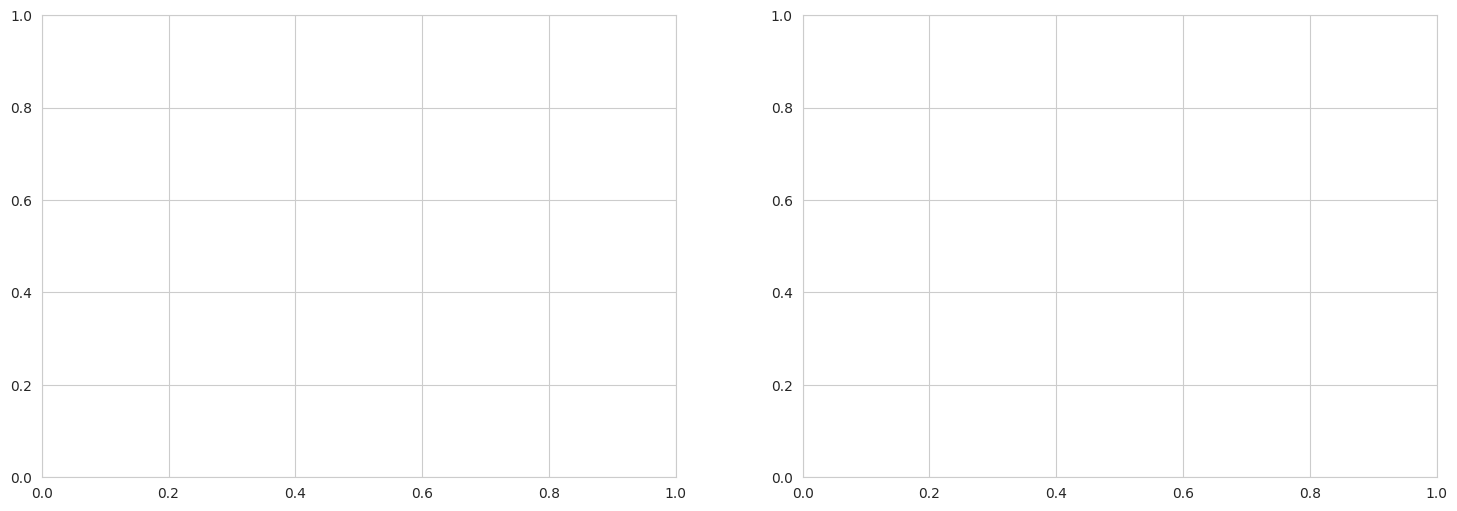

In [34]:
# Compare FHR vs THC cheapest options
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Price distribution comparison
fhr_prices = fhr_cheapest['price_per_night_inclusive_mean'].head(30)
thc_prices = thc_cheapest['price_per_night_inclusive_mean'].head(30)

axes[0].boxplot([fhr_prices, thc_prices], labels=['FHR (Top 30 Cheapest)', 'THC (Top 30 Cheapest)'])
axes[0].set_title('Price Comparison: Cheapest FHR vs THC Hotels', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Average Price per Night ($)')
axes[0].grid(True, alpha=0.3, axis='y')

# Histogram comparison
axes[1].hist(fhr_prices, bins=15, alpha=0.6, label='FHR', color='gold', edgecolor='black')
axes[1].hist(thc_prices, bins=15, alpha=0.6, label='THC', color='silver', edgecolor='black')
axes[1].set_title('Price Distribution: Top 30 Cheapest in Each Collection', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Average Price per Night ($)')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n📊 FHR vs THC CHEAPEST COMPARISON:")
print(f"  FHR - Cheapest avg: ${fhr_prices.min():.2f}/night (includes breakfast, upgrades, late checkout)")
print(f"  THC - Cheapest avg: ${thc_prices.min():.2f}/night (breakfast varies)")
print(f"  \nDifference: ${fhr_prices.min() - thc_prices.min():.2f}/night")
print(f"  \nConclusion: {'FHR cheaper!' if fhr_prices.min() < thc_prices.min() else 'THC cheaper!'} (but remember FHR includes more perks)")

In [ ]:
# Find cheapest THC hotels
thc_cheapest = (
    thc_value
    .groupby(['property_id', 'hotel_name', 'destination_name', 'address_city', 'address_country_name'])
    .agg({
        'price_per_night_inclusive': ['mean', 'min', 'max'],
        'user_rating': 'first',
        'user_rating_count': 'first',
        'is_breakfast_included': 'max',  # Show if breakfast ever included
        'is_food_beverage_credit': 'max',
        'is_parking_included': 'max',
        'check_in': ['min', 'max'],
        'snapshot_id': 'count'
    })
    .reset_index()
)

# Flatten column names
thc_cheapest.columns = ['_'.join(col).strip('_') for col in thc_cheapest.columns.values]

thc_cheapest = thc_cheapest.sort_values('price_per_night_inclusive_mean').head(30)

print("\n💰 TOP 30 CHEAPEST THC HOTELS (By Average Price):")
print("="*120)
print("⚠️  Note: Breakfast NOT included by default in THC - check 'breakfast_included' column!")
print("="*120)
display(thc_cheapest[['hotel_name', 'destination_name', 'address_city', 'address_country_name',
                       'price_per_night_inclusive_mean', 'price_per_night_inclusive_min', 
                       'price_per_night_inclusive_max', 'user_rating', 
                       'is_breakfast_included', 'is_food_beverage_credit', 
                       'is_parking_included', 'snapshot_id_count']]
        .rename(columns={
            'price_per_night_inclusive_mean': 'avg_price',
            'price_per_night_inclusive_min': 'min_price',
            'price_per_night_inclusive_max': 'max_price',
            'is_breakfast_included': 'breakfast_incl',
            'is_food_beverage_credit': 'fb_credit',
            'is_parking_included': 'parking',
            'snapshot_id_count': 'dates_available'
        })
)

# Show price distribution for cheapest THC
print(f"\n📊 CHEAPEST THC PRICE STATISTICS:")
print(f"  Lowest average price: ${thc_cheapest['price_per_night_inclusive_mean'].min():.2f}/night")
print(f"  Highest in top 30: ${thc_cheapest['price_per_night_inclusive_mean'].max():.2f}/night")
print(f"  Median of top 30: ${thc_cheapest['price_per_night_inclusive_mean'].median():.2f}/night")
print(f"\n  Hotels with breakfast: {thc_cheapest['is_breakfast_included'].sum()}/{len(thc_cheapest)}")

## 13. 💰 CHEAPEST THC HOTELS (Across Entire Calendar)

**Finding the lowest-priced THC properties - note whether breakfast is included!**

In [ ]:
# Find cheapest FHR hotels
fhr_cheapest = (
    fhr_value
    .groupby(['property_id', 'hotel_name', 'destination_name', 'address_city', 'address_country_name'])
    .agg({
        'price_per_night_inclusive': ['mean', 'min', 'max'],
        'user_rating': 'first',
        'user_rating_count': 'first',
        'is_food_beverage_credit': 'max',
        'is_parking_included': 'max',
        'check_in': ['min', 'max'],
        'snapshot_id': 'count'
    })
    .reset_index()
)

# Flatten column names
fhr_cheapest.columns = ['_'.join(col).strip('_') for col in fhr_cheapest.columns.values]

fhr_cheapest = fhr_cheapest.sort_values('price_per_night_inclusive_mean').head(30)

print("\n💰 TOP 30 CHEAPEST FHR HOTELS (By Average Price):")
print("="*120)
print("✓ ALL include: Free Breakfast, Late Checkout (4pm), Early Checkin (12pm), Room Upgrades")
print("="*120)
display(fhr_cheapest[['hotel_name', 'destination_name', 'address_city', 'address_country_name',
                       'price_per_night_inclusive_mean', 'price_per_night_inclusive_min', 
                       'price_per_night_inclusive_max', 'user_rating', 
                       'is_food_beverage_credit', 'is_parking_included', 'snapshot_id_count']]
        .rename(columns={
            'price_per_night_inclusive_mean': 'avg_price',
            'price_per_night_inclusive_min': 'min_price',
            'price_per_night_inclusive_max': 'max_price',
            'snapshot_id_count': 'dates_available'
        })
)

# Show price distribution for cheapest FHR
print(f"\n📊 CHEAPEST FHR PRICE STATISTICS:")
print(f"  Lowest average price: ${fhr_cheapest['price_per_night_inclusive_mean'].min():.2f}/night")
print(f"  Highest in top 30: ${fhr_cheapest['price_per_night_inclusive_mean'].max():.2f}/night")
print(f"  Median of top 30: ${fhr_cheapest['price_per_night_inclusive_mean'].median():.2f}/night")

## 12. 💰 CHEAPEST FHR HOTELS (Across Entire Calendar)

**Finding the lowest-priced FHR properties - remember these ALL include breakfast, upgrades, and premium perks!**

In [17]:
# Calculate value metrics for THC properties
thc_value = rates_df[rates_df['collection_type'] == 'THC'].copy()

# For THC: Breakfast IS a differentiator!
thc_value['amenity_score'] = (
    thc_value['is_breakfast_included'].fillna(0) * 3 +  # Breakfast is KEY for THC
    thc_value['is_food_beverage_credit'].fillna(0) * 3 +  
    thc_value['is_free_cancellation'].fillna(0) * 1 +
    thc_value['is_parking_included'].fillna(0) * 2 +
    thc_value['is_shuttle_included'].fillna(0) * 1
)

# Value score for THC
thc_value['quality_score'] = thc_value['user_rating'].fillna(4.0) + (thc_value['amenity_score'] * 0.1)
thc_value['value_score'] = (thc_value['quality_score'] / (thc_value['price_per_night_inclusive'] / 100)).replace([np.inf, -np.inf], np.nan)

# Get best value THC hotels
thc_best_value = (
    thc_value
    .groupby(['property_id', 'hotel_name', 'destination_name', 'address_city', 'address_country_name'])
    .agg({
        'value_score': 'mean',
        'price_per_night_inclusive': 'mean',
        'user_rating': 'first',
        'user_rating_count': 'first',
        'amenity_score': 'mean',
        'is_breakfast_included': 'max',
        'is_food_beverage_credit': 'max',
        'is_parking_included': 'max',
        'snapshot_id': 'count'
    })
    .rename(columns={'snapshot_id': 'availability_count'})
    .sort_values('value_score', ascending=False)
    .head(30)
    .reset_index()
)

print("\n🏆 TOP 30 BEST VALUE THC HOTELS:")
print("="*120)
print("(For THC, breakfast is NOT included by default - so it's a big value-add when present!)")
print("\nValue Score = (User Rating + Amenity Score) / (Price/100)")
print("="*120)
display(thc_best_value[['hotel_name', 'destination_name', 'value_score', 'price_per_night_inclusive', 
                         'user_rating', 'amenity_score', 'is_breakfast_included',
                         'is_food_beverage_credit', 'is_parking_included', 'availability_count']])


🏆 TOP 30 BEST VALUE THC HOTELS:
(For THC, breakfast is NOT included by default - so it's a big value-add when present!)

Value Score = (User Rating + Amenity Score) / (Price/100)


,hotel_name,destination_name,value_score,price_per_night_inclusive,user_rating,amenity_score,is_breakfast_included,is_food_beverage_credit,is_parking_included,availability_count
0,NH Collection Quito Royal,Ecuador,4.223539,112.798774,4.4,2.981132,0,0,1,212
1,Hyatt Centric Malta,Malta,4.073966,126.702980,4.7,2.979798,0,0,1,198
2,NH Collection San Sebastián Aránzazu,Spain,3.881578,118.153485,4.4,0.954545,0,0,0,198
3,NH Collection Porto Batalha,Portugal,3.845243,129.671278,4.6,1.000000,0,0,0,206
4,Shangri-La Lhasa,China,3.766432,133.289095,4.7,2.975309,0,0,1,162
5,"Boeira Garden Hotel Porto Gaia, Curio Collecti...",Portugal,3.705204,125.495252,4.4,0.995283,0,0,0,212
6,"Hotel Ulysses, a Member of Design Hotels",Maryland,3.626633,134.574635,4.6,0.695238,0,0,0,210
7,The Pell - Part of JdV by Hyatt,Rhode Island,3.548403,136.727606,4.5,2.981221,0,0,1,213
8,"Cenica Porto Hotel, Curio Collection by Hilton",Portugal,3.365284,144.781525,4.7,0.990566,0,0,0,212
9,Canopy by Hilton Zagreb - City Centre,Croatia,3.337032,137.541489,4.3,0.980583,0,0,0,206


In [35]:
# Calculate value metrics for FHR properties
fhr_value = rates_df[rates_df['collection_type'] == 'FHR'].copy()

# For FHR: Focus on price and quality since breakfast is always included
fhr_value['amenity_score'] = (
    fhr_value['is_food_beverage_credit'].fillna(0) * 3 +  # F&B credit is valuable
    fhr_value['is_free_cancellation'].fillna(0) * 1 +
    fhr_value['is_parking_included'].fillna(0) * 2 +  # Parking can be expensive
    fhr_value['is_shuttle_included'].fillna(0) * 1
)

# Value score: Higher user rating + more amenities + lower price = better value
# Normalize by creating a quality-to-price ratio
fhr_value['quality_score'] = fhr_value['user_rating'].fillna(4.0) + (fhr_value['amenity_score'] * 0.1)
fhr_value['value_score'] = (fhr_value['quality_score'] / (fhr_value['price_per_night_inclusive'] / 100)).replace([np.inf, -np.inf], np.nan)

# Get best value FHR hotels (across all dates)
fhr_best_value = (
    fhr_value
    .groupby(['property_id', 'hotel_name', 'destination_name', 'address_city', 'address_country_name'])
    .agg({
        'value_score': 'mean',
        'price_per_night_inclusive': 'mean',
        'user_rating': 'first',
        'user_rating_count': 'first',
        'amenity_score': 'mean',
        'is_food_beverage_credit': 'max',
        'is_parking_included': 'max',
        'snapshot_id': 'count'
    })
    .rename(columns={'snapshot_id': 'availability_count'})
    .sort_values('value_score', ascending=False)
    .head(100)
    .reset_index()
)

print("\n🏆 TOP 30 BEST VALUE FHR HOTELS:")
print("="*120)
print("(Remember: All FHR properties include breakfast, late checkout, early checkin, and room upgrades)")
print("\nValue Score = (User Rating + Amenity Score) / (Price/100)")
print("="*120)
display(fhr_best_value[['hotel_name', 'destination_name', 'value_score', 'price_per_night_inclusive', 
                         'user_rating', 'amenity_score', 'is_food_beverage_credit', 
                         'is_parking_included', 'availability_count']])


🏆 TOP 30 BEST VALUE FHR HOTELS:
(Remember: All FHR properties include breakfast, late checkout, early checkin, and room upgrades)

Value Score = (User Rating + Amenity Score) / (Price/100)


,hotel_name,destination_name,value_score,price_per_night_inclusive,user_rating,amenity_score,is_food_beverage_credit,is_parking_included,availability_count
0,"Mandarin Oriental, Jakarta",Indonesia,3.445255,154.232627,4.9,2.002825,0,1,354
1,The St. Regis Chengdu,China,3.098342,170.818255,4.9,3.000000,0,1,212
2,Tivoli Kopke Porto Gaia Hotel,Portugal,2.860230,181.419881,4.9,0.979592,0,0,196
3,InterContinental Athénée Palace Bucharest by IHG,Romania,2.834186,193.516343,4.8,0.980583,0,0,206
4,"Midtown Shangri-La, Hangzhou",China,2.685751,201.562170,5.0,2.981132,0,1,212
...,...,...,...,...,...,...,...,...,...
95,Banyan Tree Puebla,Puebla,1.488046,334.862500,4.7,1.000000,0,0,80
96,"Mandarin Oriental, Guangzhou",China,1.486984,349.000220,5.0,0.981132,0,0,212
97,"The St. Regis New Capital, Cairo",Egypt,1.475488,392.168301,4.7,2.990385,0,1,208
98,Fairmont Waterfront,British Columbia,1.473115,321.516417,4.5,1.000000,0,0,80


## 11. 💎 BEST VALUE HOTELS - DEEP DIVE

**Finding hotels that deliver the most value per dollar spent**

### Value Definition for Our Analysis:
- **FHR Properties**: Since breakfast/upgrades/late checkout are included, we focus on:
  - Price per night (lower is better)
  - User rating quality (higher is better for same price)
  - Additional amenities (F&B credit, parking, shuttle)
  
- **THC Properties**: Breakfast is a differentiator, so we consider:
  - Price per night
  - Whether breakfast is included (adds value!)
  - User rating quality
  - Additional amenities

In [15]:
# Export temporal analysis
output_dir = Path('../data/exports')
output_dir.mkdir(parents=True, exist_ok=True)

# Export temporal summary
temporal_df.to_csv(output_dir / 'temporal_analysis_filtered.csv')
print(f"✅ Exported temporal analysis to: {output_dir / 'temporal_analysis_filtered.csv'}")

# Export day of week analysis
dow_analysis.to_csv(output_dir / 'day_of_week_analysis_filtered.csv')
print(f"✅ Exported day of week analysis to: {output_dir / 'day_of_week_analysis_filtered.csv'}")

# Export destination temporal
dest_temporal.to_csv(output_dir / 'destination_temporal_filtered.csv', index=False)
print(f"✅ Exported destination temporal to: {output_dir / 'destination_temporal_filtered.csv'}")

# Export collection temporal
collection_temporal.to_csv(output_dir / 'collection_temporal_filtered.csv', index=False)
print(f"✅ Exported collection temporal to: {output_dir / 'collection_temporal_filtered.csv'}")

# Export best deals summary
best_dates.to_csv(output_dir / 'best_value_dates_filtered.csv')
print(f"✅ Exported best value dates to: {output_dir / 'best_value_dates_filtered.csv'}")

✅ Exported temporal analysis to: ../data/exports/temporal_analysis_filtered.csv
✅ Exported day of week analysis to: ../data/exports/day_of_week_analysis_filtered.csv
✅ Exported destination temporal to: ../data/exports/destination_temporal_filtered.csv
✅ Exported collection temporal to: ../data/exports/collection_temporal_filtered.csv
✅ Exported best value dates to: ../data/exports/best_value_dates_filtered.csv


In [16]:
# Close database connection
conn.close()
print("\n✓ Database connection closed")
print(f"\n✅ Analysis complete! Analyzed {len(rates_df):,} rate snapshots from {START_DATE} to {END_DATE}.")
print(f"\n📊 KEY TAKEAWAYS:")
print(f"   • Date range analyzed: {temporal_df.index.min().strftime('%Y-%m-%d')} to {temporal_df.index.max().strftime('%Y-%m-%d')}")
print(f"   • Total days: {len(temporal_df)}")
print(f"   • Average price: ${temporal_df['avg_price'].mean():.2f}/night")
print(f"   • Price range: ${temporal_df['avg_price'].min():.2f} - ${temporal_df['avg_price'].max():.2f}")
print(f"   • Unique hotels: {rates_df['property_id'].nunique()}")
print(f"   • Unique destinations: {rates_df['destination_name'].nunique()}")


✓ Database connection closed

✅ Analysis complete! Analyzed 565,593 rate snapshots from 2025-11-14 to 2026-02-23.

📊 KEY TAKEAWAYS:
   • Date range analyzed: 2025-11-14 to 2026-02-23
   • Total days: 102
   • Average price: $848.01/night
   • Price range: $706.24 - $1085.31
   • Unique hotels: 2659
   • Unique destinations: 166
